In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime as dt
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter 

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

In [3]:
def plotCSNS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time),cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

## Import data

In [4]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [5]:
#Import ros2south data
#Dec 15th 2017 - Dec 27th 2021
rostosouth_df = pd.read_csv('combined2timeseries/rostosouth17-21.csv')
datelist_rostosouth = pd.to_datetime(rostosouth_df['Date'])
rostosouth = pd.DataFrame({'Transport':rostosouth_df['Transport'].values},index=datelist_rostosouth)['Transport']

#Only 2017
rostosouth_2017_df = pd.read_csv('combined2timeseries/rostosouth_2017.csv')
datelist_rostosouth_2017 = pd.to_datetime(rostosouth_2017_df['Date'])
rostosouth_2017 = pd.DataFrame({'Transport':rostosouth_2017_df['Transport'].values},index=datelist_rostosouth_2017)['Transport']
rostosouth_2017

#Only 2018
#Dec 16th 2017 - Dec 29th 2018
rostosouth_2018_df = pd.read_csv('combined2timeseries/rostosouth_2018.csv')
datelist_rostosouth_2018 = pd.to_datetime(rostosouth_2018_df['Date'])
rostosouth_2018 = pd.DataFrame({'Transport':rostosouth_2018_df['Transport'].values},index=datelist_rostosouth_2018)['Transport']
rostosouth_2018

#Only 2019
#Jan 10th 2019 - Dec 29th 2019
rostosouth_2019_df = pd.read_csv('combined2timeseries/rostosouth_2019.csv')
datelist_rostosouth_2019 = pd.to_datetime(rostosouth_2019_df['Date'])
rostosouth_2019 = pd.DataFrame({'Transport':rostosouth_2019_df['Transport'].values},index=datelist_rostosouth_2019)['Transport']
rostosouth_2019

#Only 2020
#Jan 5th 2020 - Dec 13th 2020
rostosouth_2020_df = pd.read_csv('combined2timeseries/rostosouth_2020.csv')
datelist_rostosouth_2020 = pd.to_datetime(rostosouth_2020_df['Date'])
rostosouth_2020 = pd.DataFrame({'Transport':rostosouth_2020_df['Transport'].values},index=datelist_rostosouth_2020)['Transport']
rostosouth_2020

#Only 2021
#Dec18th 2020 - Dec 27th 2021
rostosouth_2021_df = pd.read_csv('combined2timeseries/rostosouth_2021.csv')
datelist_rostosouth_2021 = pd.to_datetime(rostosouth_2021_df['Date'])
rostosouth_2021 = pd.DataFrame({'Transport':rostosouth_2021_df['Transport'].values},index=datelist_rostosouth_2021)['Transport']

## PRtovs

#Dec 15th 2017 - Dec 27th 2021
prtovs_ros_avg_df = pd.read_csv('combined2timeseries/PRtovs_ros_avg.csv')
datelist_prtovs_ros_avg = pd.to_datetime(prtovs_ros_avg_df['Date'])
prtovs_ros_avg = pd.DataFrame({'Transport':prtovs_ros_avg_df['Transport'].values},index=datelist_prtovs_ros_avg)['Transport']

#Only 2017
#Dec 16th 2017 - Dec 29th 2018
PRtovs2017_ros_avg_df = pd.read_csv('combined2timeseries/PRtovs2017_ros_avg.csv')
datelist_prtovs_2017 = pd.to_datetime(PRtovs2017_ros_avg_df['Date'])
PRtovs2017_ros_avg = pd.DataFrame({'Transport':PRtovs2017_ros_avg_df['Transport'].values},index=datelist_prtovs_2017)['Transport']
PRtovs2017_ros_avg_df

#Only 2018
#Dec 16th 2017 - Dec 29th 2018
PRtovs2018_ros_avg_df = pd.read_csv('combined2timeseries/PRtovs2018_ros_avg.csv')
datelist_prtovs_2018 = pd.to_datetime(PRtovs2018_ros_avg_df['Date'])
PRtovs2018_ros_avg = pd.DataFrame({'Transport':PRtovs2018_ros_avg_df['Transport'].values},index=datelist_prtovs_2018)['Transport']
PRtovs2018_ros_avg_df

#Only 2019
#Jan 9th 2019 - Dec 29th 2019
PRtovs2019_ros_avg_df = pd.read_csv('combined2timeseries/PRtovs2019_ros_avg.csv')
datelist_prtovs_2019 = pd.to_datetime(PRtovs2019_ros_avg_df['Date'])
PRtovs2019_ros_avg = pd.DataFrame({'Transport':PRtovs2019_ros_avg_df['Transport'].values},index=datelist_prtovs_2019)['Transport']
PRtovs2019_ros_avg_df

#Only 2020
#Jan 5th 2020 - Dec 13th 2020
PRtovs2020_ros_avg_df = pd.read_csv('combined2timeseries/PRtovs2020_ros_avg.csv')
datelist_prtovs_2020 = pd.to_datetime(PRtovs2020_ros_avg_df['Date'])
PRtovs2020_ros_avg = pd.DataFrame({'Transport':PRtovs2020_ros_avg_df['Transport'].values},index=datelist_prtovs_2020)['Transport']
PRtovs2020_ros_avg_df

#Only 2021
#Dec18th 2020 - Dec 27th 2021
PRtovs2021_ros_avg_df = pd.read_csv('combined2timeseries/PRtovs2021_ros_avg.csv')
datelist_prtovs_2021 = pd.to_datetime(PRtovs2021_ros_avg_df['Date'])
PRtovs2021_ros_avg = pd.DataFrame({'Transport':PRtovs2021_ros_avg_df['Transport'].values},index=datelist_prtovs_2021)['Transport']
PRtovs2021_ros_avg_df

## PRtoadm

#Dec 14th 2017 - Dec 27th 2021
prtoadm_ros_avg_df = pd.read_csv('combined2timeseries/PRtoadm_ros_avg.csv')
datelist_prtoadm_ros_avg = pd.to_datetime(prtoadm_ros_avg_df['Date'])
prtoadm_ros_avg = pd.DataFrame({'Transport':prtoadm_ros_avg_df['Transport'].values},index=datelist_prtoadm_ros_avg)['Transport']

#Only 2017
#Dec 13th 2017 - Dec 29th 2018
PRtoadm2017_ros_avg_df = pd.read_csv('combined2timeseries/PRtoadm2017_ros_avg.csv')
datelist_prtoadm_2017 = pd.to_datetime(PRtoadm2017_ros_avg_df['Date'])
PRtoadm2017_ros_avg = pd.DataFrame({'Transport':PRtoadm2017_ros_avg_df['Transport'].values},index=datelist_prtoadm_2017)['Transport']
PRtoadm2017_ros_avg_df

#Only 2018
#Dec 13th 2017 - Dec 29th 2018
PRtoadm2018_ros_avg_df = pd.read_csv('combined2timeseries/PRtoadm2018_ros_avg.csv')
datelist_prtoadm_2018 = pd.to_datetime(PRtoadm2018_ros_avg_df['Date'])
PRtoadm2018_ros_avg = pd.DataFrame({'Transport':PRtoadm2018_ros_avg_df['Transport'].values},index=datelist_prtoadm_2018)['Transport']
PRtoadm2018_ros_avg_df

#Only 2019
#Jan 10th 2019 - Dec 29th 2019
PRtoadm2019_ros_avg_df = pd.read_csv('combined2timeseries/PRtoadm2019_ros_avg.csv')
datelist_prtoadm_2019 = pd.to_datetime(PRtoadm2019_ros_avg_df['Date'])
PRtoadm2019_ros_avg = pd.DataFrame({'Transport':PRtoadm2019_ros_avg_df['Transport'].values},index=datelist_prtoadm_2019)['Transport']
PRtoadm2019_ros_avg_df

#Only 2020
#Jan 3th 2020 - Dec 13th 2020
PRtoadm2020_ros_avg_df = pd.read_csv('combined2timeseries/PRtoadm2020_ros_avg.csv')
datelist_prtoadm_2020 = pd.to_datetime(PRtoadm2020_ros_avg_df['Date'])
PRtoadm2020_ros_avg = pd.DataFrame({'Transport':PRtoadm2020_ros_avg_df['Transport'].values},index=datelist_prtoadm_2020)['Transport']
PRtoadm2020_ros_avg_df

#Only 2021
#Dec17th 2020 - Dec 27th 2021
PRtoadm2021_ros_avg_df = pd.read_csv('combined2timeseries/PRtoadm2021_ros_avg.csv')
datelist_prtoadm_2021 = pd.to_datetime(PRtoadm2021_ros_avg_df['Date'])
PRtoadm2021_ros_avg = pd.DataFrame({'Transport':PRtoadm2021_ros_avg_df['Transport'].values},index=datelist_prtoadm_2021)['Transport']
rostosouth_2018

# Import Haro data

## PR to VS

# Full
prtovs_haro_avg_df = pd.read_csv('combined2timeseries/PRtovs18_21_haro_avg.csv')
datelist_prtovs_haro_avg = pd.to_datetime(prtovs_haro_avg_df['Date'])
prtovs_haro_avg = pd.DataFrame({'Transport':prtovs_haro_avg_df['Transport'].values},index=datelist_prtovs_haro_avg)['Transport']

# #Only 2017
PRtovs2017_haro_avg_df = pd.read_csv('combined2timeseries/PRtovs2017_haro_avg.csv')
datelist_prtovs_haro2017 = pd.to_datetime(PRtovs2017_haro_avg_df['Date'])
PRtovs2017_haro_avg = pd.DataFrame({'Transport':PRtovs2017_haro_avg_df['Transport'].values},index=datelist_prtovs_haro2017)['Transport']

# #Only 2018
PRtovs2018_haro_avg_df = pd.read_csv('combined2timeseries/PRtovs2018_haro_avg.csv')
datelist_prtovs_haro2018 = pd.to_datetime(PRtovs2018_haro_avg_df['Date'])
PRtovs2018_haro_avg = pd.DataFrame({'Transport':PRtovs2018_haro_avg_df['Transport'].values},index=datelist_prtovs_haro2018)['Transport']

# #Only 2019
PRtovs2019_haro_avg_df = pd.read_csv('combined2timeseries/PRtovs2019_haro_avg.csv')
datelist_prtovs_haro2019 = pd.to_datetime(PRtovs2019_haro_avg_df['Date'])
PRtovs2019_haro_avg = pd.DataFrame({'Transport':PRtovs2019_haro_avg_df['Transport'].values},index=datelist_prtovs_haro2019)['Transport']

# #Only 2020
PRtovs2020_haro_avg_df = pd.read_csv('combined2timeseries/PRtovs2020_haro_avg.csv')
datelist_prtovs_haro2020 = pd.to_datetime(PRtovs2020_haro_avg_df['Date'])
PRtovs2020_haro_avg = pd.DataFrame({'Transport':PRtovs2020_haro_avg_df['Transport'].values},index=datelist_prtovs_haro2020)['Transport']

# #Only 202q
PRtovs2021_haro_avg_df = pd.read_csv('combined2timeseries/PRtoVS2021_haro_avg.csv')
datelist_prtovs_haro2021 = pd.to_datetime(PRtovs2021_haro_avg_df['Date'])
PRtovs2021_haro_avg = pd.DataFrame({'Transport':PRtovs2021_haro_avg_df['Transport'].values},index=datelist_prtovs_haro2021)['Transport']

# #Only 2021
# PRtovs2021_haro_avg_df = pd.read_csv('combined2timeseries/PRtovs2021_haro_avg.csv')
# datelist_prtovs_haro2021 = pd.to_datetime(PRtovs2021_haro_avg_df['Date'])
# PRtovs2021_haro_avg = pd.DataFrame({'Transport':PRtovs2021_haro_avg_df['Transport'].values},index=datelist_prtovs_haro2021)['Transport']

## Gulf to VS

# Full
Gulftovs_haro_avg_df = pd.read_csv('combined2timeseries/Gulftovs18_21_haro_avg.csv')
datelist_Gulftovs_haro_avg = pd.to_datetime(Gulftovs_haro_avg_df['Date'])
Gulftovs_haro_avg = pd.DataFrame({'Transport':Gulftovs_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_avg)['Transport']

# #Only 2017
# Gulftovs2017_haro_avg_df = pd.read_csv('combined2timeseries/Gulftovs2017_haro_avg.csv')
# datelist_Gulftovs_haro_2017 = pd.to_datetime(Gulftovs2017_haro_avg_df['Date'])
# Gulftovs2017_haro_avg = pd.DataFrame({'Transport':Gulftovs_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_2017)['Transport']

# # #Only 2018
Gulftovs2018_haro_avg_df = pd.read_csv('combined2timeseries/Gulftovs2018_haro_avg.csv')
datelist_Gulftovs_haro_2018 = pd.to_datetime(Gulftovs2018_haro_avg_df['Date'])
Gulftovs2018_haro_avg = pd.DataFrame({'Transport':Gulftovs2018_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_2018)['Transport']

# # #Only 2019
Gulftovs2019_haro_avg_df = pd.read_csv('combined2timeseries/Gulftovs2019_haro_avg.csv')
datelist_Gulftovs_haro_2019 = pd.to_datetime(Gulftovs2019_haro_avg_df['Date'])
Gulftovs2019_haro_avg = pd.DataFrame({'Transport':Gulftovs2019_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_2019)['Transport']

# # #Only 2020
Gulftovs2020_haro_avg_df = pd.read_csv('combined2timeseries/Gulftovs2020_haro_avg.csv')
datelist_Gulftovs_haro_2020 = pd.to_datetime(Gulftovs2020_haro_avg_df['Date'])
Gulftovs2020_haro_avg = pd.DataFrame({'Transport':Gulftovs2020_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_2020)['Transport']

# # #Only 2021
Gulftovs2021_haro_avg_df = pd.read_csv('combined2timeseries/Gulftovs2021_haro_avg.csv')
datelist_Gulftovs_haro_2021 = pd.to_datetime(Gulftovs2021_haro_avg_df['Date'])
Gulftovs2021_haro_avg = pd.DataFrame({'Transport':Gulftovs2021_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_2021)['Transport']

# Vs to PR

# Full
VStoPR_haro_avg_df = pd.read_csv('combined2timeseries/VStoPR18_21_haro_avg.csv')
datelist_VStoPR_haro_avg = pd.to_datetime(VStoPR_haro_avg_df['Date'])
VStoPR_haro_avg = pd.DataFrame({'Transport':VStoPR_haro_avg_df['Transport'].values},index=datelist_VStoPR_haro_avg)['Transport']

# #Only 2017
# Gulftovs2017_haro_avg_df = pd.read_csv('combined2timeseries/Gulftovs2017_haro_avg.csv')
# datelist_Gulftovs_haro_2017 = pd.to_datetime(Gulftovs2017_haro_avg_df['Date'])
# Gulftovs2017_haro_avg = pd.DataFrame({'Transport':Gulftovs_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_2017)['Transport']

# # #Only 2018
VStoPR2018_haro_avg_df = pd.read_csv('combined2timeseries/VStoPR2018_haro_avg.csv')
datelist_VStoPR_haro_2018 = pd.to_datetime(VStoPR2018_haro_avg_df['Date'])
VStoPR2018_haro_avg = pd.DataFrame({'Transport':VStoPR2018_haro_avg_df['Transport'].values},index=datelist_VStoPR_haro_2018)['Transport']

# # #Only 2019
VStoPR2019_haro_avg_df = pd.read_csv('combined2timeseries/VStoPR2019_haro_avg.csv')
datelist_VStoPR_haro_2019 = pd.to_datetime(VStoPR2019_haro_avg_df['Date'])
VStoPR2019_haro_avg = pd.DataFrame({'Transport':VStoPR2019_haro_avg_df['Transport'].values},index=datelist_VStoPR_haro_2019)['Transport']

# # #Only 2020
VStoPR2020_haro_avg_df = pd.read_csv('combined2timeseries/VStoPR2020_haro_avg.csv')
datelist_VStoPR_haro_2020 = pd.to_datetime(VStoPR2020_haro_avg_df['Date'])
VStoPR2020_haro_avg = pd.DataFrame({'Transport':VStoPR2020_haro_avg_df['Transport'].values},index=datelist_VStoPR_haro_2020)['Transport']

# # #Only 2021
VStoPR2021_haro_avg_df = pd.read_csv('combined2timeseries/VStoPR2021_haro_avg.csv')
datelist_VStoPR_haro_2021 = pd.to_datetime(VStoPR2021_haro_avg_df['Date'])
VStoPR2021_haro_avg = pd.DataFrame({'Transport':VStoPR2021_haro_avg_df['Transport'].values},index=datelist_VStoPR_haro_2021)['Transport']

# VS to Gulf

# Full
VStogulf_haro_avg_df = pd.read_csv('combined2timeseries/VStogulf18_21_haro_avg.csv')
datelist_VStogulf_haro_avg = pd.to_datetime(VStogulf_haro_avg_df['Date'])
VStogulf_haro_avg = pd.DataFrame({'Transport':VStogulf_haro_avg_df['Transport'].values},index=datelist_VStogulf_haro_avg)['Transport']

# #Only 2017
# Gulftovs2017_haro_avg_df = pd.read_csv('combined2timeseries/Gulftovs2017_haro_avg.csv')
# datelist_Gulftovs_haro_2017 = pd.to_datetime(Gulftovs2017_haro_avg_df['Date'])
# Gulftovs2017_haro_avg = pd.DataFrame({'Transport':Gulftovs_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_2017)['Transport']

# # #Only 2018
VStogulf2018_haro_avg_df = pd.read_csv('combined2timeseries/VStogulf2018_haro_avg.csv')
datelist_VStogulf_haro_2018 = pd.to_datetime(VStogulf2018_haro_avg_df['Date'])
VStogulf2018_haro_avg = pd.DataFrame({'Transport':VStogulf2018_haro_avg_df['Transport'].values},index=datelist_VStogulf_haro_2018)['Transport']

# # #Only 2019
VStogulf2019_haro_avg_df = pd.read_csv('combined2timeseries/VStogulf2019_haro_avg.csv')
datelist_VStogulf_haro_2019 = pd.to_datetime(VStogulf2019_haro_avg_df['Date'])
VStogulf2019_haro_avg = pd.DataFrame({'Transport':VStogulf2019_haro_avg_df['Transport'].values},index=datelist_VStogulf_haro_2019)['Transport']

# # #Only 2020
VStogulf2020_haro_avg_df = pd.read_csv('combined2timeseries/VStogulf2020_haro_avg.csv')
datelist_VStogulf_haro_2020 = pd.to_datetime(VStogulf2020_haro_avg_df['Date'])
VStogulf2020_haro_avg = pd.DataFrame({'Transport':VStogulf2020_haro_avg_df['Transport'].values},index=datelist_VStogulf_haro_2020)['Transport']

# # #Only 2021
VStogulf2021_haro_avg_df = pd.read_csv('combined2timeseries/VStogulf2021_haro_avg.csv')
datelist_VStogulf_haro_2021 = pd.to_datetime(VStogulf2021_haro_avg_df['Date'])
VStogulf2021_haro_avg = pd.DataFrame({'Transport':VStogulf2021_haro_avg_df['Transport'].values},index=datelist_VStogulf_haro_2021)['Transport']

### Import density data

In [6]:
# Importing density and tidal data

density_vspr = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2016-22_202111_mean.csv')
dens_diff_vspr = np.array(density_vspr.south - density_vspr.north)

density_ros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2016-22_rosarioNS.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)

tides_1d = pd.read_csv('../notebooks/day_avg_tide_BP_16-22.csv')
tides = tides_1d['vozocrtx'].rolling(4, center=True).mean()
# tides_ros = pd.read_csv('low_pass_tide_18-22.csv')

date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length
 
date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)
    
print(len(datelist_dens))
print(len(dens_diff_ros))   

2557
2557


In [7]:
wind = pd.read_csv('../notebooks/day_avg_wind_16-22.csv')
x = wind['time']
y = wind['wind']

date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_winds = []

while date <= enddate:
    datelist_winds.append(date)
    date+=dt.timedelta(days=1)
    
y_mean4 = y.rolling(window=4, center=True).mean()

print(len(y_mean4),len(datelist_winds))

2557 2557


In [8]:
wind = pd.read_csv('../notebooks/day_avg_wind_racerocks_16-22.csv')
x = wind['time']
y = wind['wind']

y_mean4_rr = y.rolling(window=4, center=True).mean()

print(len(y_mean4_rr),len(datelist_winds))

2557 2557


0.8080048434059938


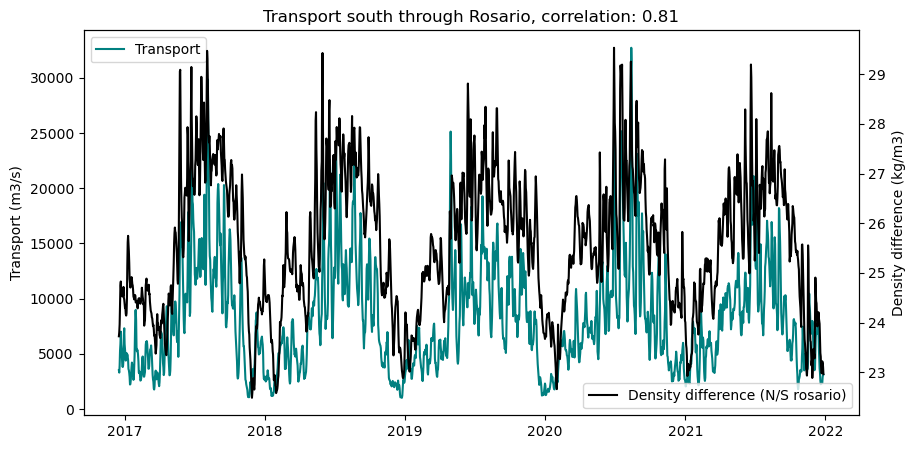

In [9]:
date_rossh = list(rostosouth.dropna().index)

mask = np.isin(datelist_dens,date_rossh)
densdiff_ros = dens_diff_ros[mask]
date_dens_sh = np.array(datelist_dens)[mask]

corr_rostosouth,p = stats.spearmanr(densdiff_ros,rostosouth.dropna())
print(corr_rostosouth)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(rostosouth.dropna(),color='teal',label='Transport')
ax2=ax.twinx()
ax2.plot(date_dens_sh,densdiff_ros,color='k',label='Density difference (N/S rosario)')
ax.set_title(f'Transport south through Rosario, correlation: {np.round(corr_rostosouth,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend(loc=2)
ax2.legend()

2706.2199138531773 -61080.464933308074


Text(0.5, 1.0, 'South through rosario, correlation = -0.111')

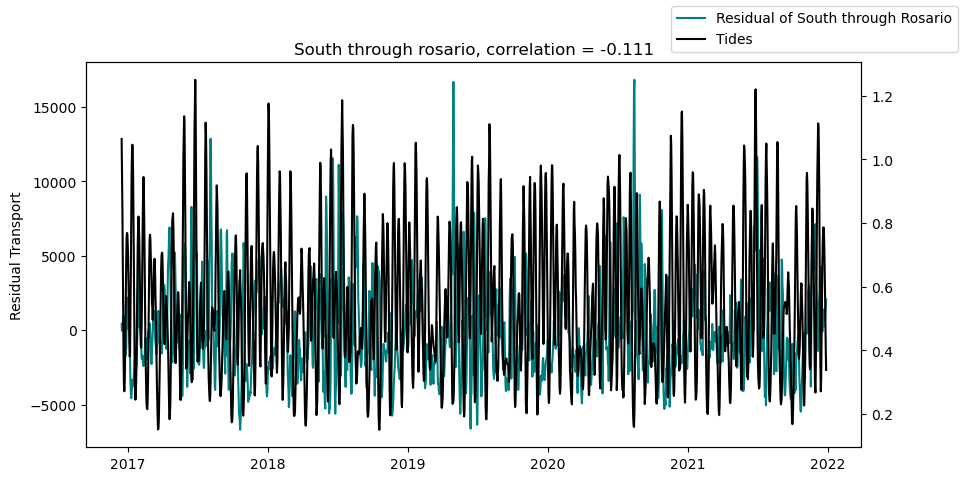

In [10]:
slope,intercept = np.polyfit(densdiff_ros,rostosouth.dropna(),1)
ddline = slope*densdiff_ros+intercept
res = rostosouth.dropna() - ddline
print(slope,intercept)

mask = np.isin(datelist_tides,date_rossh)
date_tides_sh = np.array(datelist_tides)[mask]
tides_sh = tides[mask]

corr_res_ros,p = stats.spearmanr(tides_sh,res)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='k',label='Tides')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'South through rosario, correlation = {np.round(corr_res_ros,3)}')

Text(0.5, 1.0, 'corr = -0.139')

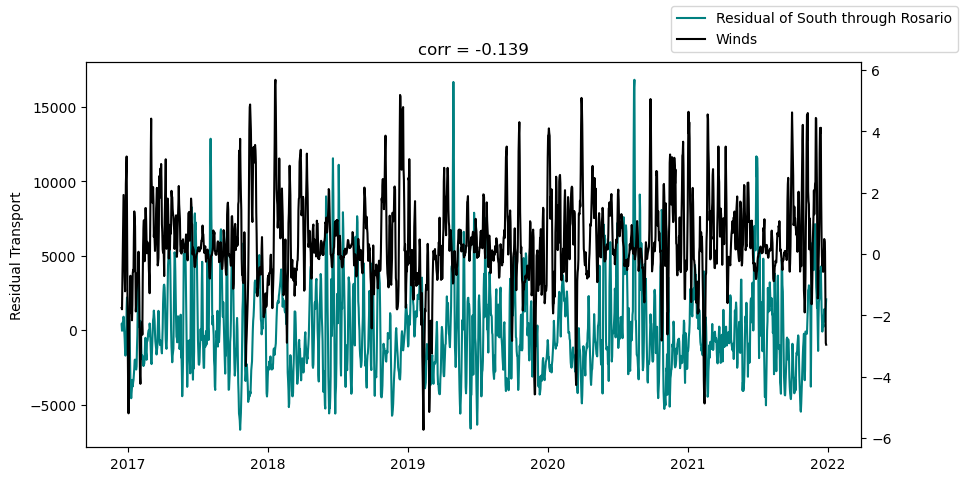

In [11]:
mask = np.isin(datelist_winds,date_rossh)
date_winds_sh = np.array(datelist_winds)[mask]
winds_sh = y_mean4[mask]

corr_res_ros_wind,p = stats.spearmanr(winds_sh,res)
corr_res_ros_wind

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_winds_sh,winds_sh,color='k',label='Winds')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr_res_ros_wind,3)}')

### Through Haro

Text(0, 0.5, 'Transport (m3/s)')

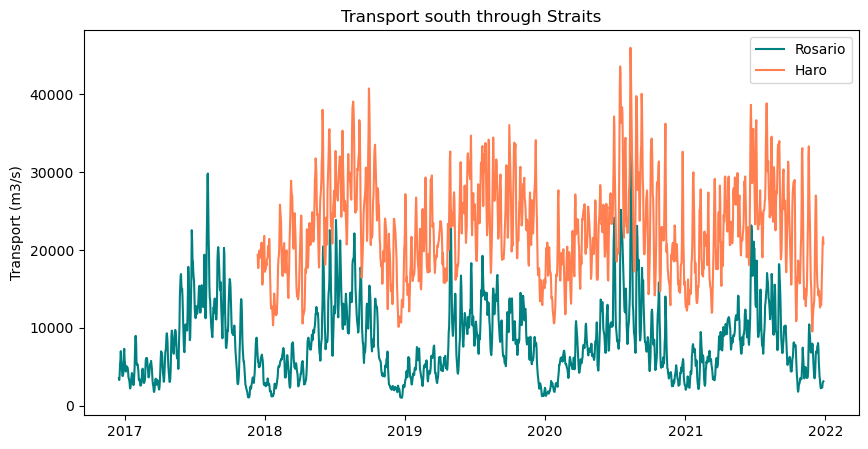

In [12]:
harotosouth = prtovs_haro_avg + Gulftovs_haro_avg
date_harosh = list(harotosouth.dropna().index)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(rostosouth.dropna(),label='Rosario',color='teal')
ax.plot(harotosouth.dropna(),label='Haro',color='coral')
ax.legend()
ax.set_title(f'Transport south through Straits')
ax.set_ylabel('Transport (m3/s)')

#### Correlations with transport south through Haro

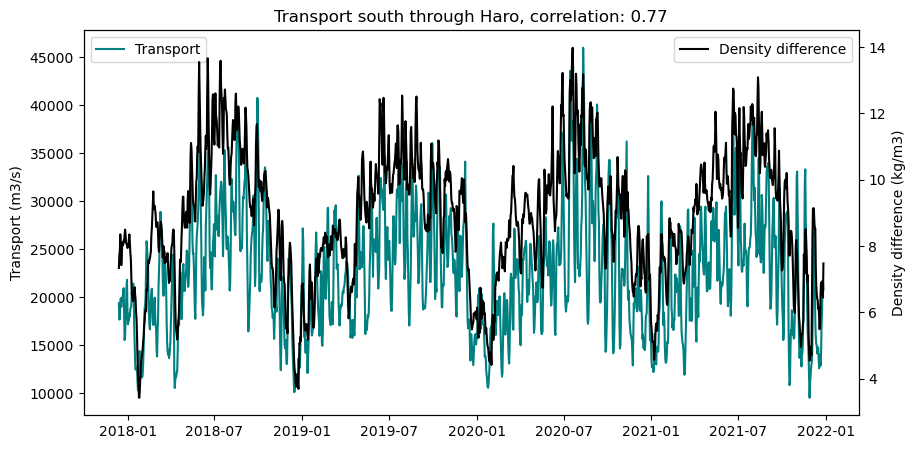

In [13]:
date_harosh = list(harotosouth.dropna().index)

mask = np.isin(datelist_dens,date_harosh)
densdiff_haro = dens_diff_vspr[mask]
date_dens_haro_sh = np.array(datelist_dens)[mask]

corr_harotosouth,p = stats.spearmanr(densdiff_haro,harotosouth.dropna())

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(harotosouth.dropna(),color='teal',label='Transport')
ax2=ax.twinx()
ax2.plot(date_dens_haro_sh,densdiff_haro,color='k',label='Density difference')
ax.set_title(f'Transport south through Haro, correlation: {np.round(corr_harotosouth,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend(loc=2)
ax2.legend()

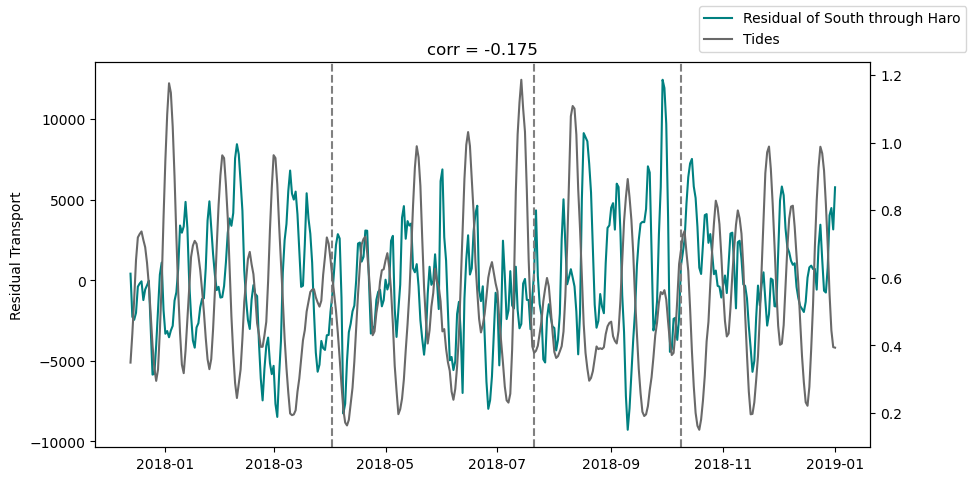

In [14]:
slope,intercept = np.polyfit(densdiff_haro,harotosouth.dropna(),1)
ddline_haro = slope*densdiff_haro+intercept
res_haro = harotosouth.dropna() - ddline_haro

mask = np.isin(datelist_tides,date_harosh)
date_tides_haro_sh = np.array(datelist_tides)[mask]
tides_haro_sh = tides[mask]

corr_res_haro,p = stats.spearmanr(tides_haro_sh[0:385],res_haro[0:385])

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro[0:385],color='teal',label='Residual of South through Haro')
ax2 = ax.twinx()
ax2.plot(date_tides_haro_sh[0:385],tides_haro_sh[0:385],color='dimgrey',label='Tides')
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr_res_haro,3)}')
# ax.plot(rostosouth.dropna(),label='Transport south through Rosario')
# ax.plot(res,label='Residual south through Rosario',color='darkblue')
ax.axvline(date_tides_haro_sh[110],ls='--',color='grey')
ax.axvline(date_tides_haro_sh[220],ls='--',color='grey')
ax.axvline(date_tides_haro_sh[300],ls='--',color='grey')
# ax3 = ax.twinx()
# ax3.plot(date_winds_sh,winds_sh,color='darkgrey',label='Winds')
# ax3.spines['right'].set_position(('outward', 80))
fig.legend()

In [15]:
corr,p = stats.spearmanr(tides_haro_sh[0:110],res_haro[0:110])
print(corr)
corr,p = stats.spearmanr(tides_haro_sh[100:200],res_haro[100:200])
print(corr)

-0.5038478010955075
0.20183618361836184


Text(0, 0.5, 'Wind velocity')

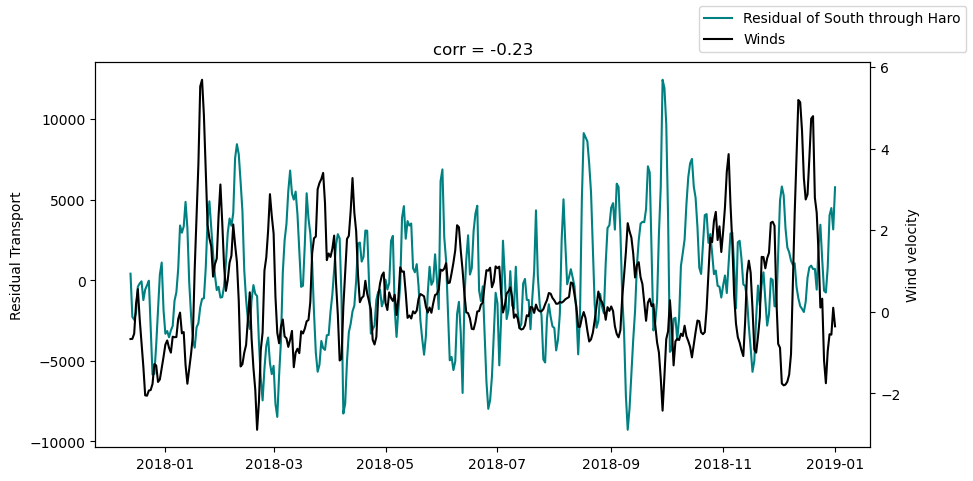

In [16]:
mask = np.isin(datelist_winds,date_harosh)
date_winds_sh = np.array(datelist_winds)[mask]
winds_haro = y_mean4[mask]

corr,p = stats.spearmanr(winds_haro[0:385],res_haro[0:385])
corr

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro[0:385],color='teal',label='Residual of South through Haro')
ax2 = ax.twinx()
ax2.plot(date_winds_sh[0:385],winds_haro[0:385],color='k',label='Winds')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')
ax2.set_ylabel('Wind velocity')

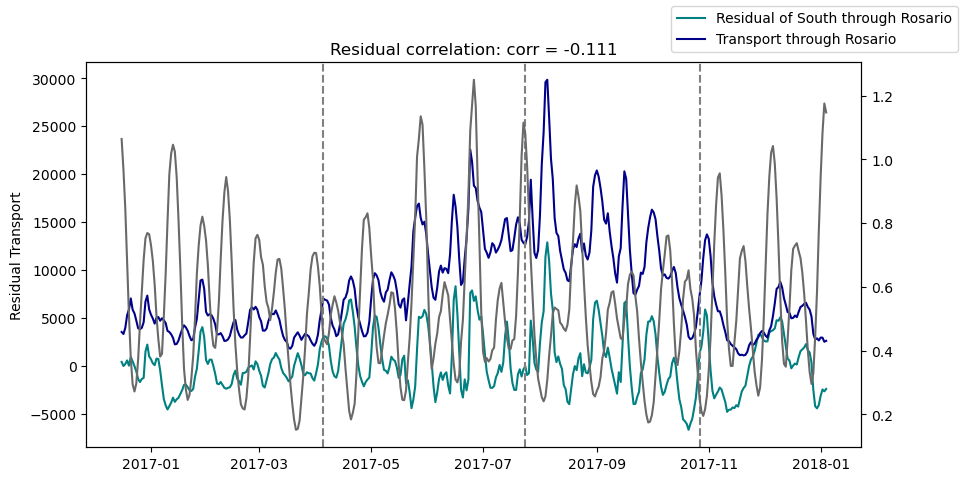

In [17]:
corr,p = stats.spearmanr(winds_haro[0:385],res_haro[0:385])
corr

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res[0:385],color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh[0:385],tides_sh[0:385],color='dimgrey')
ax.plot(rostosouth.dropna()[0:385],color='darkblue',label='Transport through Rosario')
# ax.plot(harotosouth.dropna(),color='sienna',label='Transport through Haro')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'Residual correlation: corr = {np.round(corr_res_ros,3)}')
ax.axvline(date_tides_sh[110],ls='--',color='grey')
ax.axvline(date_tides_sh[220],ls='--',color='grey')
ax.axvline(date_tides_sh[315],ls='--',color='grey')

**High correlation of transport to the wind (likely because the wind and density difference are highly correlated) - residual high correlation with the tides and very low with the winds

-0.18907197439307533
0.10446092464441088
-0.061614408403399226
0.32228208191510943


Text(0.5, 1.0, 'Zone 2: Correlation: -0.189')

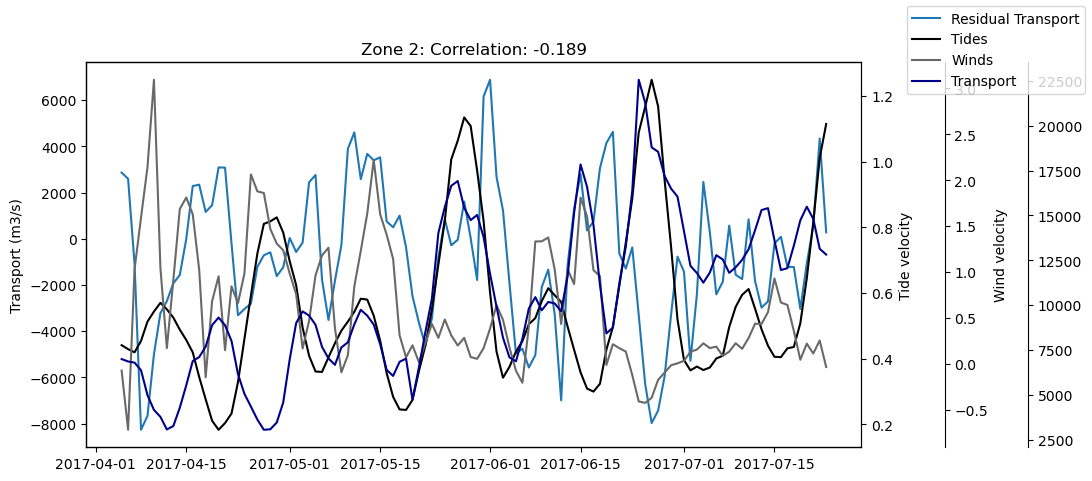

In [18]:
aa = date_tides_sh[110:220]
a = res_haro[113:223]
b = tides_sh[110:220]
c = winds_sh[110:220]
d = rostosouth.dropna()[110:220]
e = res[110:220]

corr1,p = stats.spearmanr(a,b)
print(corr1)
corr2,p = stats.spearmanr(a,c)
print(corr2)
corr3,p = stats.spearmanr(b,e)
print(corr3)
corr4,p = stats.spearmanr(b,d)
print(corr4)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(aa,a,label='Residual Transport')
ax2 = ax.twinx()
ax2.plot(aa,b,color='k',label='Tides')
ax3 = ax.twinx()
ax3.plot(aa,c,color='dimgrey',label='Winds')
ax3.spines['right'].set_position(('outward', 60))
ax4 = ax.twinx()
ax4.plot(aa,d,color='darkblue',label='Transport')
ax4.spines['right'].set_position(('outward', 120))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Wind velocity')
fig.legend()
ax.set_title(f'Zone 2: Correlation: {np.round(corr1,3)}')

### North through Haro

#### VicSill to Point Rob

In [19]:
date = dt.datetime(2017,12,10)
enddate = dt.datetime(2020,12,28)

datelist_forvs_haro = []

while date <= enddate:
    datelist_forvs_haro.append(date)
    date+=dt.timedelta(days=1)
    
datelist_forvs_haro.pop(506)

datetime.datetime(2019, 4, 30, 0, 0)

Text(0, 0.5, 'Transport (m3/s)')

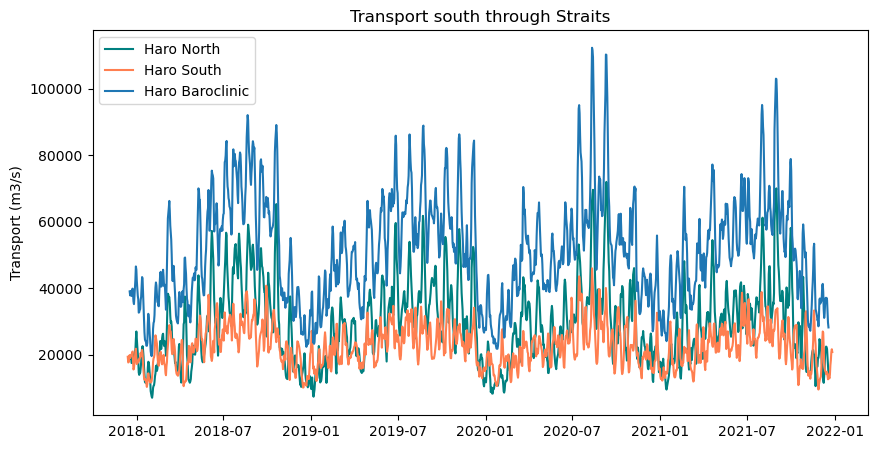

In [20]:
harotonorth = VStogulf_haro_avg + VStoPR_haro_avg
date_haroNsh = list(harotonorth.dropna().index)
haro_bclin = (harotosouth.dropna()+harotonorth.dropna()).dropna()
date_haro_bclin = list(haro_bclin.index)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(harotonorth.dropna(),label='Haro North',color='teal')
ax.plot(harotosouth.dropna(),label='Haro South',color='coral')
ax.plot(haro_bclin.dropna(),label='Haro Baroclinic')
ax.legend()
ax.set_title(f'Transport south through Straits')
ax.set_ylabel('Transport (m3/s)')

In [21]:
corr = stats.spearmanr(harotonorth.dropna(),haro_bclin.dropna())
print(corr)
corr = stats.spearmanr(harotosouth.dropna()[:-13],haro_bclin.dropna())
print(corr)

SignificanceResult(statistic=0.9393843486680253, pvalue=0.0)
SignificanceResult(statistic=0.5530210648670357, pvalue=5.832760551039538e-118)


#### Correlations with baroclinic velocity

0.7977244510764375


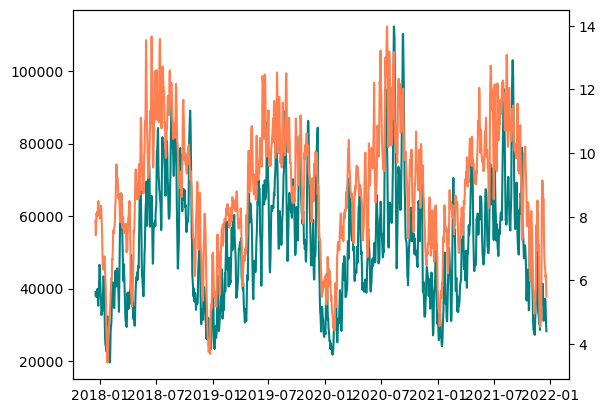

In [22]:
mask = np.isin(datelist_dens,date_haro_bclin)
densdiff_haro_bclin = dens_diff_vspr[mask]
date_dens_haro_bclin = np.array(datelist_dens)[mask]

corr_haro_bclin_DD,p = stats.spearmanr(densdiff_haro_bclin,haro_bclin)
print(corr_haro_bclin_DD)

fig,ax = plt.subplots()

ax.plot(haro_bclin,color='teal',label='Baroclinic Transport - Haro')
ax2 = ax.twinx()
ax2.plot(date_dens_haro_bclin,densdiff_haro_bclin,color='coral')

In [23]:
mask = np.isin(datelist_dens,date_harosh)
densdiff_vspr_haroS = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_vspr_haroS,harotosouth.dropna())
corr

0.7747267443503992

In [24]:
mask = np.isin(datelist_dens,date_haroNsh)
densdiff_vspr_haroN = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_vspr_haroN,harotonorth.dropna())
corr

0.6786510579109747

North is less correlated with density difference. Baroclinic and south are about the same

0.6786510579109747


Text(0, 0.5, 'Tide velocity ')

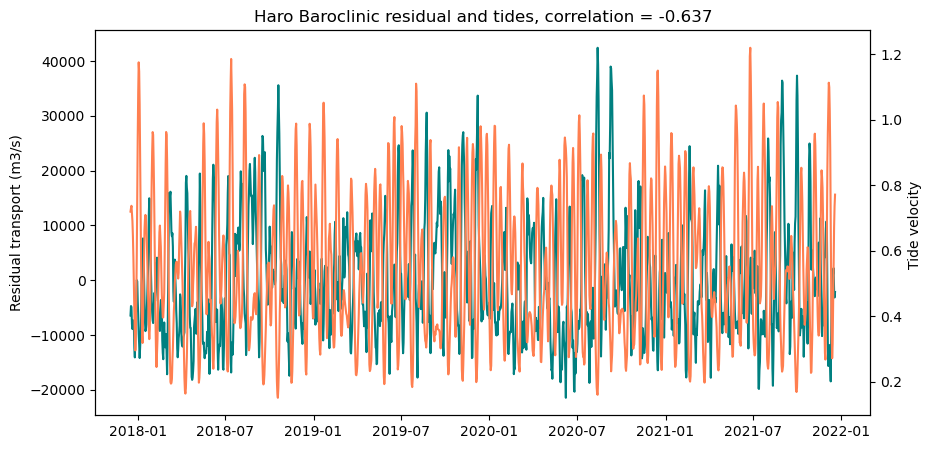

In [25]:
slope,intercept = np.polyfit(densdiff_haro_bclin,haro_bclin,1)
ddline_haro_bclin = slope*densdiff_haro_bclin+intercept
res_haro_bclin = haro_bclin - ddline_haro_bclin

mask = np.isin(datelist_tides,date_haro_bclin)
tides_haro_bclin = tides[mask]
date_tides_haro_bclin = np.array(datelist_tides)[mask]

corr_res_haro_bclin_tides,p = stats.spearmanr(tides_haro_bclin,res_haro_bclin)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haro_bclin,label='Residual Haro',color='teal')
ax2 = ax.twinx()
ax2.plot(date_tides_haro_bclin,tides_haro_bclin,color='coral',label='Tides')
ax.set_title(f'Haro Baroclinic residual and tides, correlation = {np.round(corr_res_haro_bclin_tides,3)}')
# ax.axvline(date_tides_sh[idx_z2],ls='--',color='grey')
# ax.axvline(date_tides_sh[idx_z3],ls='--',color='grey')
# ax.axvline(date_tides_sh[idx_z4],ls='--',color='grey')
# ax.axvline(date_tides_sh[idx_z1],ls='--',color='grey')
ax.set_ylabel('Residual transport (m3/s)')
ax2.set_ylabel('Tide velocity ')

Baroclinic velocity strongly negatively correlated ... but south flow NOT

Check north flow ...

-0.5789951253308858


Text(0, 0.5, 'Tide velocity ')

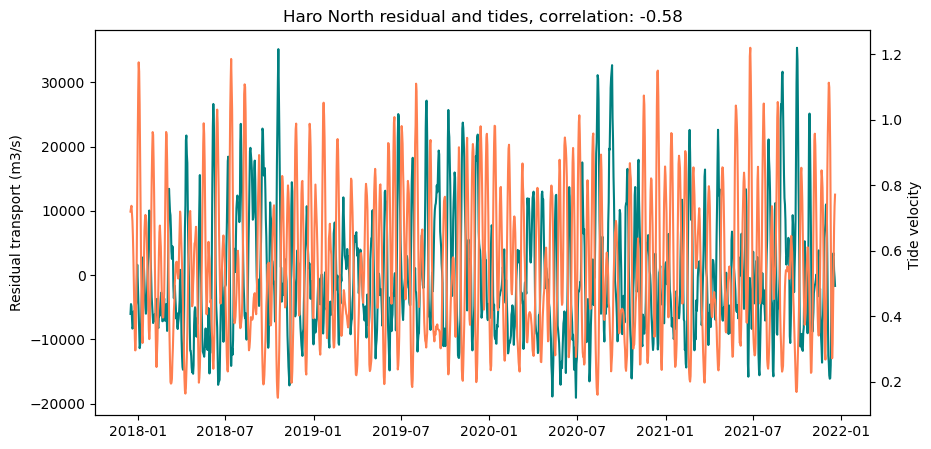

In [26]:
slope,intercept = np.polyfit(densdiff_vspr_haroN,harotonorth.dropna(),1)

ddline_haroN = slope*densdiff_vspr_haroN+intercept
res_haroN = harotonorth.dropna() - ddline_haroN

mask = np.isin(datelist_tides,date_haroNsh)
tides_haroN = tides[mask]
date_tides_haroN = np.array(datelist_tides)[mask]

corr,p = stats.spearmanr(tides_haroN,res_haroN)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haroN,color='teal')
ax2 = ax.twinx()
ax2.plot(date_tides_haroN,tides_haroN,color='coral')
ax.set_title(f'Haro North residual and tides, correlation: {np.round(corr,2)}')
ax.set_ylabel('Residual transport (m3/s)')
ax2.set_ylabel('Tide velocity ')

-0.5576254542090034
-0.5852348381318221


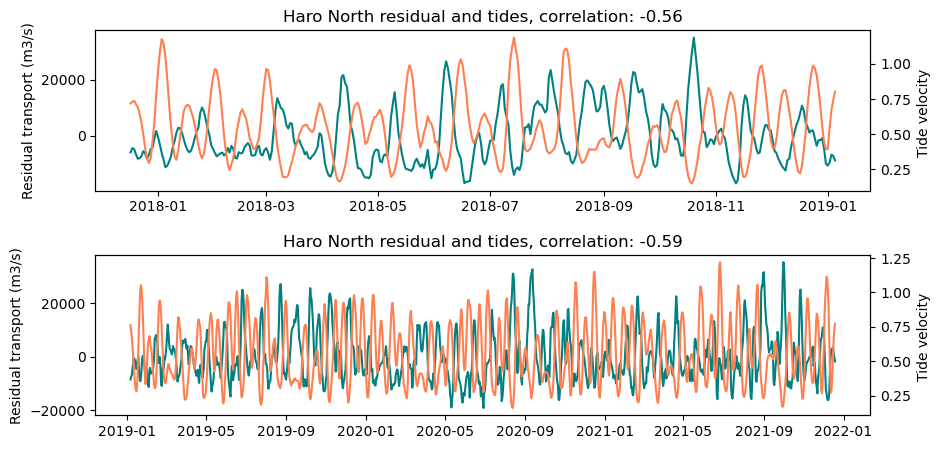

In [27]:
corr,p = stats.spearmanr(tides_haroN[0:385],res_haroN[0:385])
print(corr)

fig,[ax,ax3] = plt.subplots(2,1,figsize=(10,5))

ax.plot(res_haroN[0:385],color='teal')
ax2 = ax.twinx()
ax2.plot(date_tides_haroN[0:385],tides_haroN[0:385],color='coral')
ax.set_title(f'Haro North residual and tides, correlation: {np.round(corr,2)}')
ax.set_ylabel('Residual transport (m3/s)')
ax2.set_ylabel('Tide velocity ')

corr,p = stats.spearmanr(tides_haroN[385:],res_haroN[385:])
print(corr)

ax3.plot(res_haroN[385:],color='teal')
ax32 = ax3.twinx()
ax32.plot(date_tides_haroN[385:],tides_haroN[385:],color='coral')
ax3.set_title(f'Haro North residual and tides, correlation: {np.round(corr,2)}')
ax3.set_ylabel('Residual transport (m3/s)')
ax32.set_ylabel('Tide velocity ')

fig.subplots_adjust(hspace=0.4)

-0.2609921623079307


Text(0, 0.5, 'Tide velocity ')

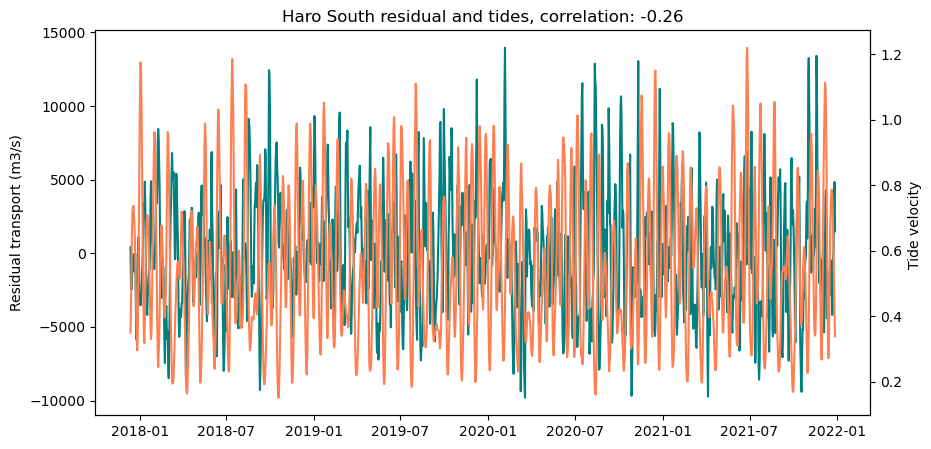

In [28]:
slope,intercept = np.polyfit(densdiff_vspr_haroS,harotosouth.dropna(),1)

ddline_haroS = slope*densdiff_vspr_haroS+intercept
res_haroS = harotosouth.dropna() - ddline_haroS

date_haroSsh = list(harotosouth.dropna().index)
mask = np.isin(datelist_tides,date_haroSsh)
tides_haroS = tides[mask]
date_tides_haroS = np.array(datelist_tides)[mask]

corr,p = stats.spearmanr(tides_haroS,res_haroS)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haroS,color='teal')
# ax.plot(res_haro_bclin)
# ax.plot(res_haro,color='lightblue')
ax2 = ax.twinx()
ax2.plot(date_tides_haroS,tides_haroS,color='coral')
ax.set_title(f'Haro South residual and tides, correlation: {np.round(corr,2)}')

ax.set_ylabel('Residual transport (m3/s)')
ax2.set_ylabel('Tide velocity ')

#### Calculate residual with density difference to Haro 

0.7747267443503992
0.7747267443503992


Text(0.5, 1.0, 'Haro South and density difference')

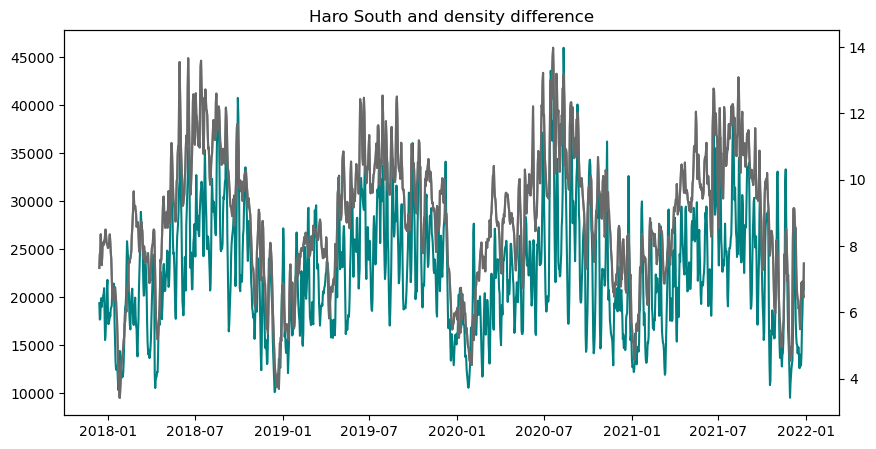

In [29]:
mask = np.isin(datelist_dens,date_harosh)
densdiff_haro2 = dens_diff_vspr[mask]

corr_harotosouth2,p = stats.spearmanr(densdiff_haro2,harotosouth.dropna())
print(corr_harotosouth2)
print(corr_harotosouth)

fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(harotosouth.dropna(),color='teal')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_dens)[mask],densdiff_haro2,color='grey')
ax2.plot(np.array(datelist_dens)[mask],densdiff_haro,color='dimgrey')
ax.set_title('Haro South and density difference')

-0.2609921623079307


Text(0.5, 0.98, 'HaroSouth residial and tides')

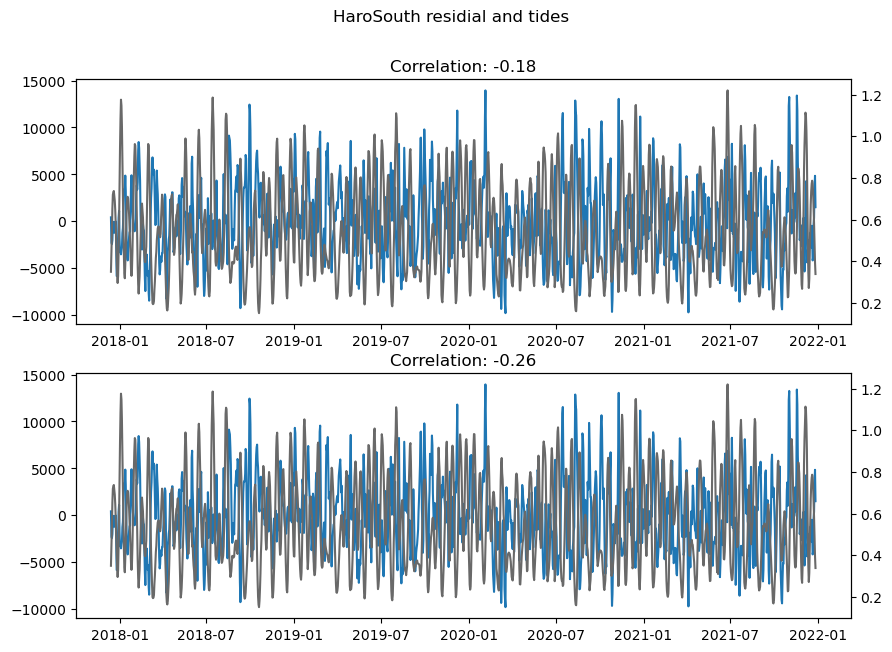

In [30]:
slope,intercept = np.polyfit(densdiff_haro2,harotosouth.dropna(),1)
ddline_haro2 = slope*densdiff_haro2+intercept
res_haro2 = harotosouth.dropna() - ddline_haro2

corr_res_haro2,p = stats.spearmanr(tides_haro_sh,res_haro2)
print(corr_res_haro2)

fig,ax = plt.subplots(2,1,figsize=(10,7))

ax[0].plot(res_haro)
ax[1].plot(res_haro2)
ax2 = ax[0].twinx()
ax2.plot(date_tides_haro_sh,tides_haro_sh,color='dimgrey')
ax3 = ax[1].twinx()
ax3.plot(date_tides_haro_sh,tides_haro_sh,color='dimgrey')
ax[0].set_title(f'Correlation: {np.round(corr_res_haro,2)}')
ax[1].set_title(f'Correlation: {np.round(corr_res_haro2,2)}')
fig.suptitle('HaroSouth residial and tides')

Text(0, 0.5, 'Tide velocity')

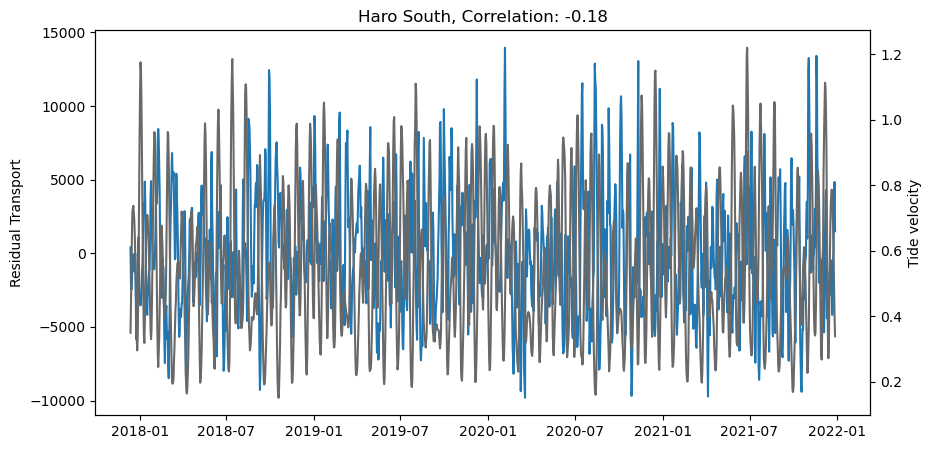

In [31]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(res_haro)
ax2 = ax.twinx()
ax2.plot(date_tides_haro_sh,tides_haro_sh,color='dimgrey')
ax.set_title(f'Haro South, Correlation: {np.round(corr_res_haro,2)}')
ax.set_ylabel('Residual Transport')
ax2.set_ylabel('Tide velocity')

- Split up baroclinic haro into the subregions
- Maximize correlation with densdiff_haro, and see if this is the same patterns as rosario

#### Baroclinic

In [32]:
idx_z1 = 15
idx_z2 = 110
idx_z3 = 240
idx_z4 = 320


transp_haro_bclinz1 = haro_bclin.dropna()[idx_z1:idx_z2]
tides_haro_bclinz1 = tides_haro_bclin[idx_z1:idx_z2]
transp_haro_bclinz2 = haro_bclin.dropna()[idx_z2:idx_z3]
tides_haro_bclinz2 = tides_haro_bclin[idx_z2:idx_z3]
transp_haro_bclinz3 = haro_bclin.dropna()[idx_z3:idx_z4]
tides_haro_bclinz3 = tides_haro_bclin[idx_z3:idx_z4]
transp_haro_bclinz4 = haro_bclin.dropna()[idx_z4:]
tides_haro_bclinz4 = tides_haro_bclin[idx_z4:]

corr,p = stats.spearmanr(tides_haro_bclinz1,transp_haro_bclinz1)
print('Zone1:',corr)
corr,p = stats.spearmanr(tides_haro_bclinz2,transp_haro_bclinz2)
print('Zone2:',corr)
corr,p = stats.spearmanr(tides_haro_bclinz3,transp_haro_bclinz3)
print('Zone3:',corr)
corr,p = stats.spearmanr(tides_haro_bclinz4,transp_haro_bclinz4)
print('Zone4:',corr)

Zone1: -0.4618980963045913
Zone2: -0.217845389121796
Zone3: -0.8107829348335679
Zone4: -0.39905672146388116


Varying degrees of negative correlation consistent with zones from +/- of HaroS 

-> Look at HaroN

In [33]:
transp_haroNz1 = harotonorth.dropna()[idx_z1:idx_z2]
tides_haroNz1 = tides_haroN[idx_z1:idx_z2]
transp_haroNz2 = harotonorth.dropna()[idx_z2:idx_z3]
tides_haroNz2 = tides_haroN[idx_z2:idx_z3]
transp_haroNz3 = harotonorth.dropna()[idx_z3:idx_z4]
tides_haroNz3 = tides_haroN[idx_z3:idx_z4]
transp_haroNz4 = harotonorth.dropna()[idx_z4:]
tides_haroNz4 = tides_haroN[idx_z4:]

corr,p = stats.spearmanr(tides_haroNz1,transp_haroNz1)
print('Zone1:',corr)
corr,p = stats.spearmanr(tides_haroNz2,transp_haroNz2)
print('Zone2:',corr)
corr,p = stats.spearmanr(tides_haroNz3,transp_haroNz3)
print('Zone3:',corr)
corr,p = stats.spearmanr(tides_haroNz4,transp_haroNz4)
print('Zone4:',corr)

Zone1: -0.2950447928331467
Zone2: -0.3830804735828701
Zone3: -0.8206516643225505
Zone4: -0.4416375255213044


- Zone 1 to 2 switch must be because of haroS since consistent correlation in zone1
- Zone 2 to 3 switch doubles in HaroN therefore that change is because of HaroN
- Zone 3 to 4 switch must be caused by HaroS signal

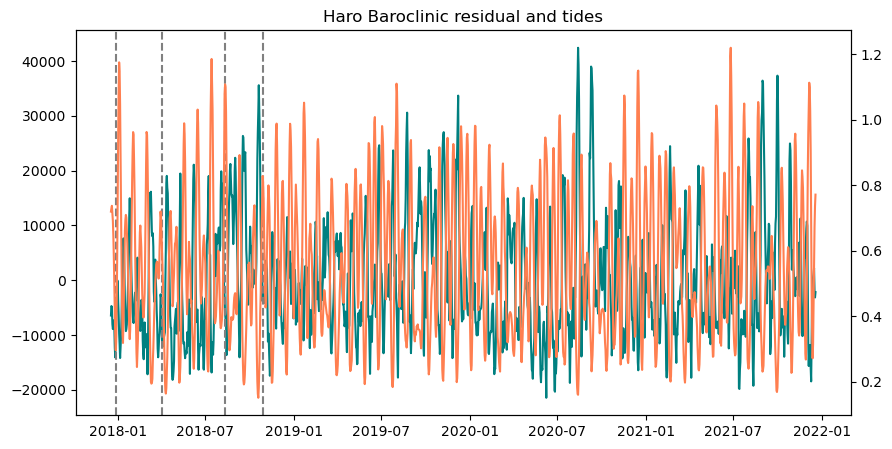

In [34]:

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haro_bclin,label='Residual Haro',color='teal')
ax2 = ax.twinx()
ax2.plot(date_tides_haro_bclin,tides_haro_bclin,color='coral',label='Tides')
ax.set_title('Haro Baroclinic residual and tides')
ax.axvline(date_tides_haro_sh[idx_z2],ls='--',color='grey')
ax.axvline(date_tides_haro_sh[idx_z3],ls='--',color='grey')
ax.axvline(date_tides_haro_sh[idx_z4],ls='--',color='grey')
ax.axvline(date_tides_haro_sh[idx_z1],ls='--',color='grey')

## Look at barotropic Haro

Text(0, 0.5, 'Transport (m3/s)')

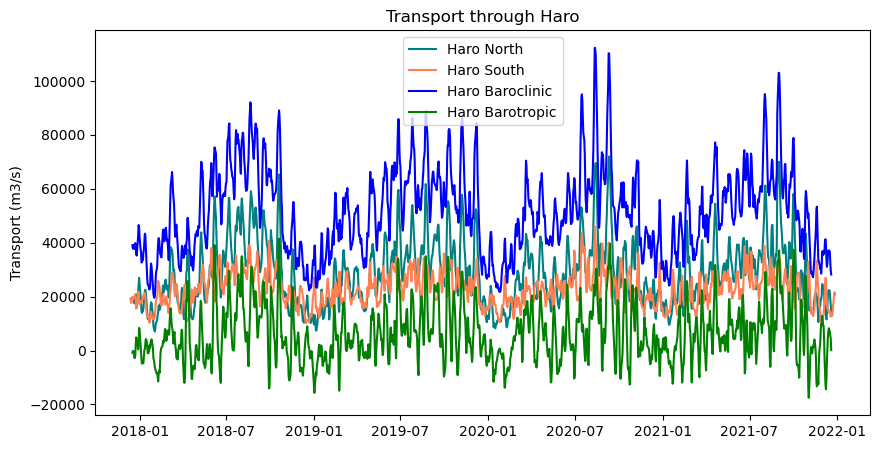

In [35]:
haro_btrop = (harotonorth-harotosouth).dropna()
date_haro_btrop = list(haro_bclin.index)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(harotonorth.dropna(),label='Haro North',color='teal')
ax.plot(harotosouth.dropna(),label='Haro South',color='coral')
ax.plot(haro_bclin.dropna(),label='Haro Baroclinic',color='blue')
ax.plot(haro_btrop.dropna(),label='Haro Barotropic',color='green')
ax.legend()
ax.set_title(f'Transport through Haro')
ax.set_ylabel('Transport (m3/s)')

0.30757648467234666
-0.41124052187058774


Text(0, 0.5, 'Tide velocity')

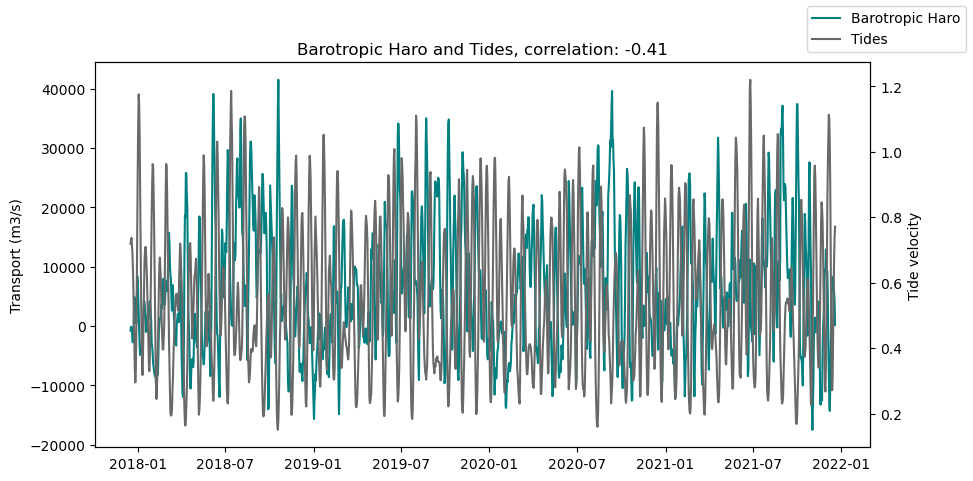

In [36]:
mask = np.isin(datelist_dens,date_haro_btrop)
densdiff_haro_btrop = dens_diff_vspr[mask]
date_DD_haro_btrop = np.array(datelist_dens)[mask]

corr_DD_haro_btrop,p = stats.spearmanr(haro_btrop,densdiff_haro_btrop)
print(corr_DD_haro_btrop)

mask = np.isin(datelist_tides,date_haro_btrop)
tides_haro_btrop = tides[mask]
date_tides_haro_btrop = np.array(datelist_tides)[mask]

corr_tides_haro_btrop,p = stats.spearmanr(tides_haro_btrop,haro_btrop)
print(corr_tides_haro_btrop)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(haro_btrop,label='Barotropic Haro',color='teal')
ax2 = ax.twinx()
ax2.plot(date_tides_haro_btrop,tides_haro_btrop,color='dimgrey',label='Tides')
fig.legend()
ax.set_title(f'Barotropic Haro and Tides, correlation: {np.round(corr_tides_haro_btrop,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')

Text(0.5, 1.0, 'Barotropic Haro and density difference, correlation: 0.31')

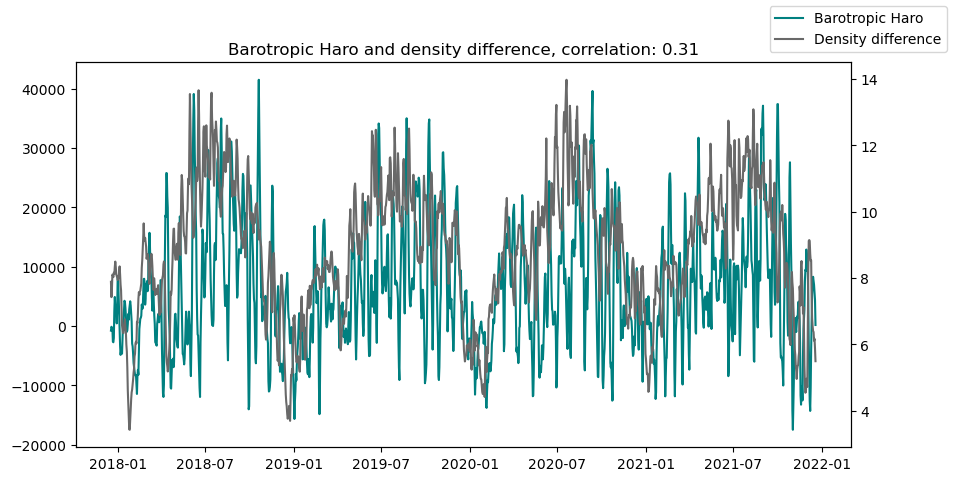

In [37]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(haro_btrop,label='Barotropic Haro',color='teal')
ax2 = ax.twinx()
ax2.plot(date_DD_haro_btrop,densdiff_haro_btrop,color='dimgrey',label='Density difference')
fig.legend()
ax.set_title(f'Barotropic Haro and density difference, correlation: {np.round(corr_DD_haro_btrop,2)}')

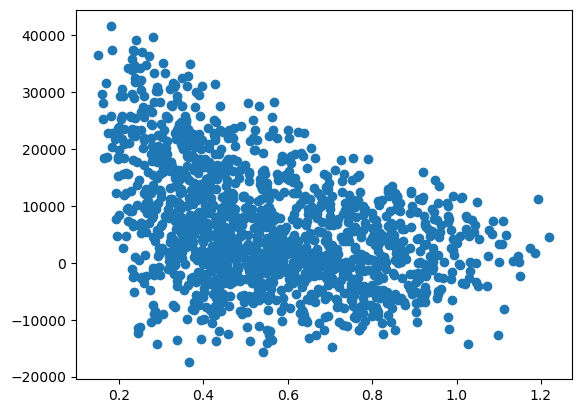

In [38]:
plt.scatter(tides_haro_btrop,haro_btrop)

In [39]:
slope,intercept = np.polyfit(tides_haro_btrop,haro_btrop,1)
tides_line_haro_btrop = slope*tides_haro_btrop+intercept
res_haro_btrop_tides = haro_btrop.values - tides_line_haro_btrop.values

corr_resharo_btrop_DD,p = stats.spearmanr(densdiff_haro_btrop,res_haro_btrop_tides)
print(corr_resharo_btrop_DD)

0.32882389101840986


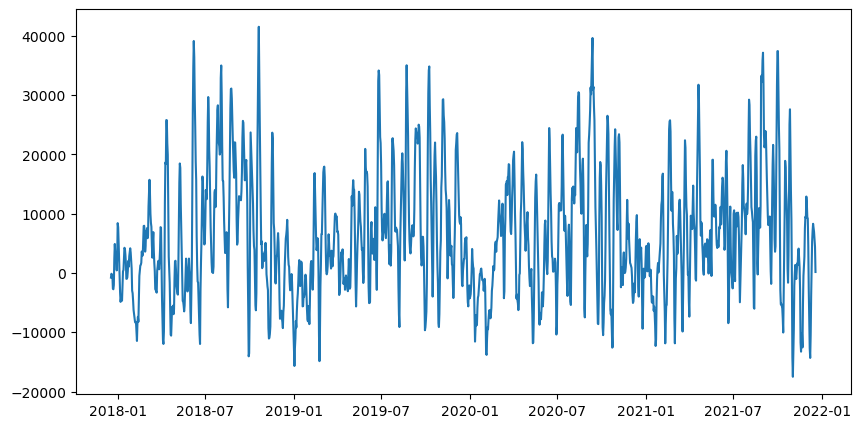

In [40]:
fig,ax = plt.subplots(figsize=(10,5))

# ax.plot(haro_bclin)
ax.plot(haro_btrop)

0.6069893237745732


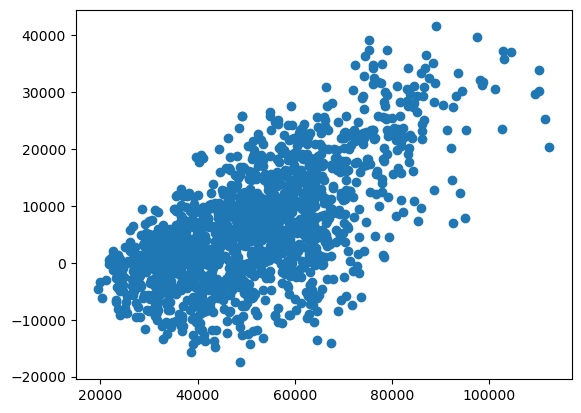

In [41]:
plt.scatter(haro_bclin,haro_btrop)
corr,p = stats.spearmanr(haro_bclin,haro_btrop)
print(corr)

### Sea Surface Height

2191 2191
0.29655669461052664


Text(0.5, 1.0, 'Baroclinic Haro and SSH, corr: 0.3')

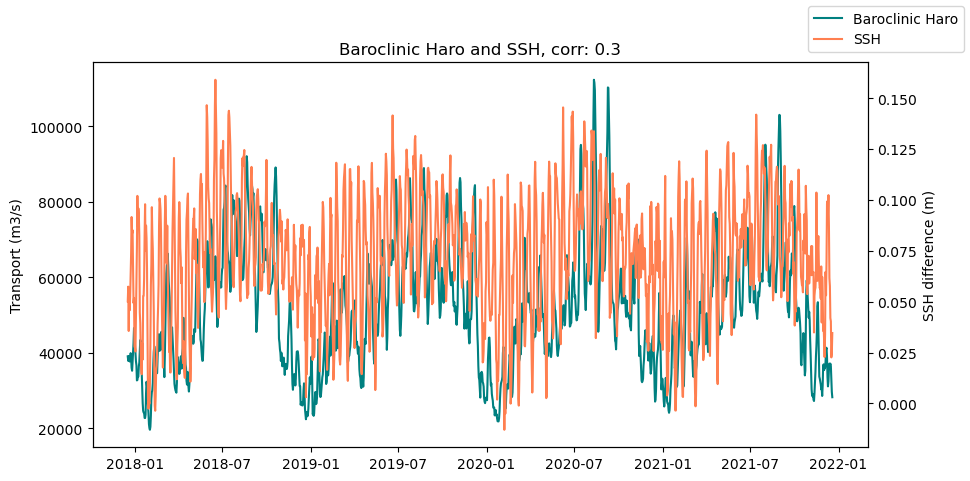

In [42]:
delta_ssh_data = pd.read_csv('../notebooks/ssh_4day_mean_17-22.csv')
# ssh_vicsill_data = pd.read_csv('../notebooks/ssh_vicsill_4day_mean.csv')
jdf_vicsill_data = pd.read_csv('../notebooks/ssh_jdf_4day_mean_17-22.csv')
# jdf7_vicsill_data = pd.read_csv('../notebooks/ssh_jdf_7day_mean.csv')
# datelist_ssh = delta_ssh_data['Unnamed: 0']
delta_ssh = delta_ssh_data['SSH']
# ssh_vicsill = ssh_vicsill_data['SSH']
# ssh_jdf7 = jdf7_vicsill_data['SSH']
ssh_jdf = jdf_vicsill_data['SSH']

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)

dates = []
datelist_ssh = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_ssh.append(date)
    date+=dt.timedelta(days=1)

#Look at through Haro (baroclinic) and SSH

print(len(datelist_ssh),len(jdf_vicsill_data))

mask = np.isin(datelist_ssh,date_haro_bclin)
ssh_haro_bclin = delta_ssh[mask]
date_ssh_haro_bclin = np.array(datelist_ssh)[mask]

corr,p = stats.spearmanr(ssh_haro_bclin,haro_bclin)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(haro_bclin,color='teal',label='Baroclinic Haro')
ax2 = ax.twinx()
ax2.plot(date_ssh_haro_bclin,ssh_haro_bclin,color='coral',label='SSH')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('SSH difference (m)')
fig.legend()
ax.set_title(f'Baroclinic Haro and SSH, corr: {np.round(corr,2)}')


Remove tides from both and re-look

### Variance explained

In [43]:
mask = np.isin(datelist_winds,date_haro_bclin)
winds_haro_bclin = y_mean4[mask]

# Correlation of all with og transport

corr_dd,p = stats.spearmanr(densdiff_haro_bclin,haro_bclin)
corr_tides,p = stats.spearmanr(tides_haro_bclin,haro_bclin)
corr_winds,p = stats.spearmanr(winds_haro_bclin,haro_bclin)
corr_ssh,p = stats.spearmanr(ssh_haro_bclin,haro_bclin)
print(corr_dd**2,corr_tides**2,corr_winds**2,corr_ssh**2)

np.sum((corr_dd**2,corr_tides**2,corr_winds**2,corr_ssh**2))

0.6363642998452036 0.15219755510447291 0.020775413696694243 0.08794587311832117


0.8972831417646918

In [44]:
# Baroclinic haro + residual with tides

print(corr_haro_bclin_DD**2,corr_res_haro_bclin_tides**2)

0.6363642998452036 0.40543940008263446


In [45]:
# Correlation of ssh with others

corr,p = stats.spearmanr(winds_haro_bclin,ssh_haro_bclin)
corr2,p = stats.spearmanr(tides_haro_bclin,ssh_haro_bclin)
print(corr,corr2)

0.016759134396160516 0.09644555460120086


#### Winds, SSH and baroclinic/barotropic

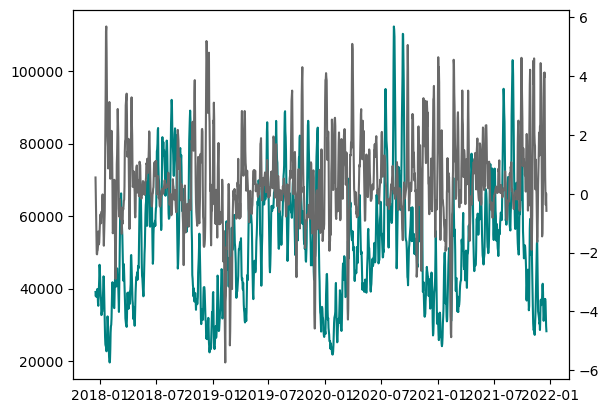

In [46]:
fig,ax = plt.subplots()

ax.plot(haro_bclin,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,winds_haro_bclin,color='dimgrey')

In [47]:
corr,p = stats.spearmanr(winds_haro_bclin,haro_bclin)
print('Winds and transport through Haro:',corr)

corr,p = stats.spearmanr(densdiff_haro_bclin,winds_haro_bclin)
print('Winds and density diff:',corr)

Winds and transport through Haro: -0.14413678814478365
Winds and density diff: -0.23062841088073938


0.08286527831686226


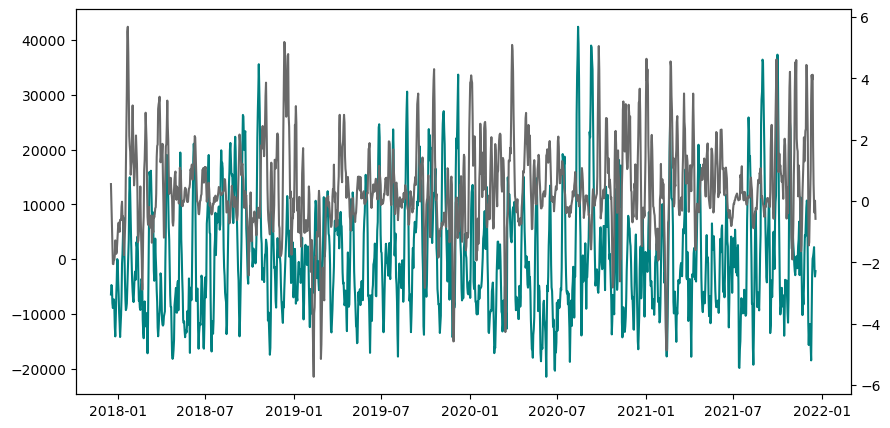

In [48]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haro_bclin,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,winds_haro_bclin,color='dimgrey')

corr,p = stats.spearmanr(winds_haro_bclin,res_haro_bclin)
print(corr)

Not really a relationship here, look at ssh

-0.12680123298208845


Text(0.5, 1.0, 'Residual baroclinic haro, corr: -0.13')

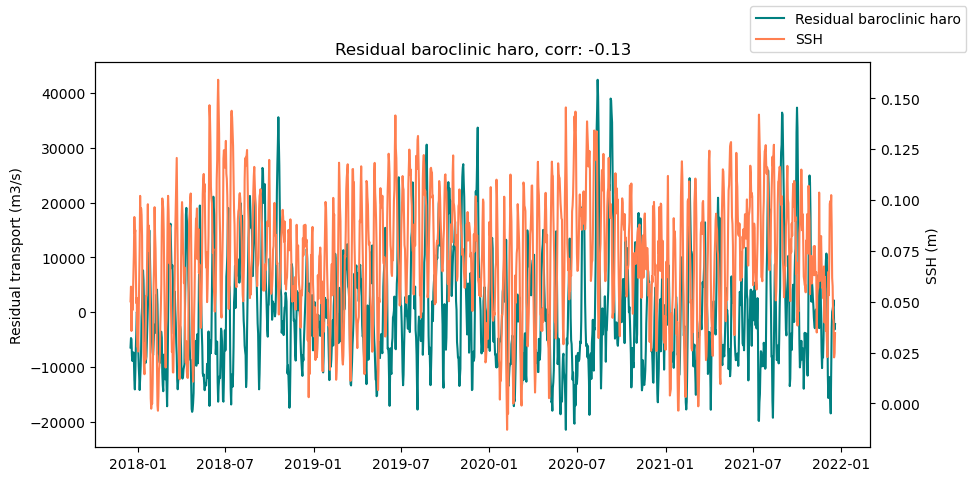

In [49]:
corr,p = stats.spearmanr(ssh_haro_bclin,res_haro_bclin)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haro_bclin,label='Residual baroclinic haro',color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,ssh_haro_bclin,label='SSH',color='coral')
fig.legend()
ax.set_ylabel('Residual transport (m3/s)')
ax2.set_ylabel('SSH (m)')
ax.set_title(f'Residual baroclinic haro, corr: {np.round(corr,2)}')


Slightly more of something but tides + ssh likely have some sort of relationship

Take residual after tides

0.08343417263732789


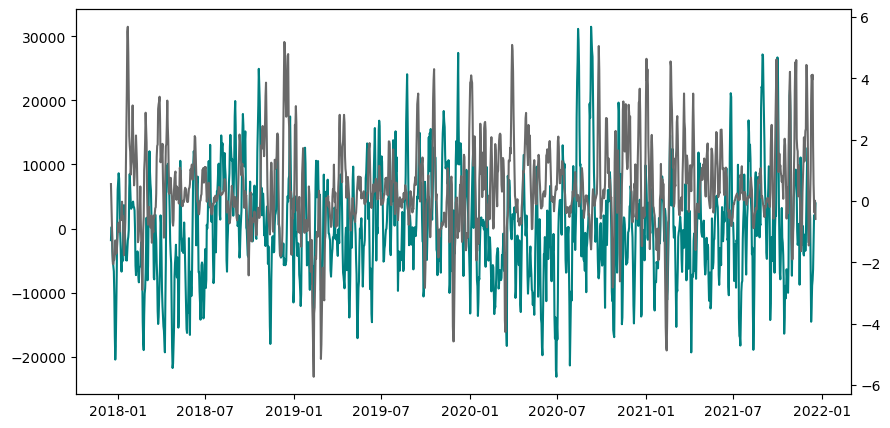

In [50]:
## Remove tides

slope,intercept = np.polyfit(tides_haro_bclin,res_haro_bclin,1)
tideline_haro_bclin = slope*tides_haro_bclin + intercept
res_haro_bclin_tides = res_haro_bclin.values - tideline_haro_bclin

corr,p = stats.spearmanr(winds_haro_bclin,res_haro_bclin_tides)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(date_haro_bclin,res_haro_bclin_tides,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,winds_haro_bclin,color='dimgrey')

-0.05933127710622344


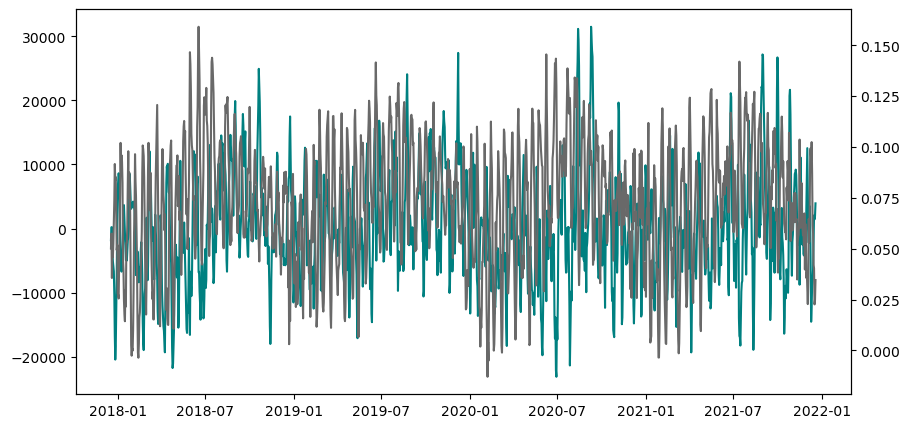

In [51]:
corr,p = stats.spearmanr(ssh_haro_bclin,res_haro_bclin_tides)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(date_haro_bclin,res_haro_bclin_tides,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,ssh_haro_bclin,color='dimgrey')

Nothing here really either --> next, barotropic

#### Haro barotropic

0.11830829006763731


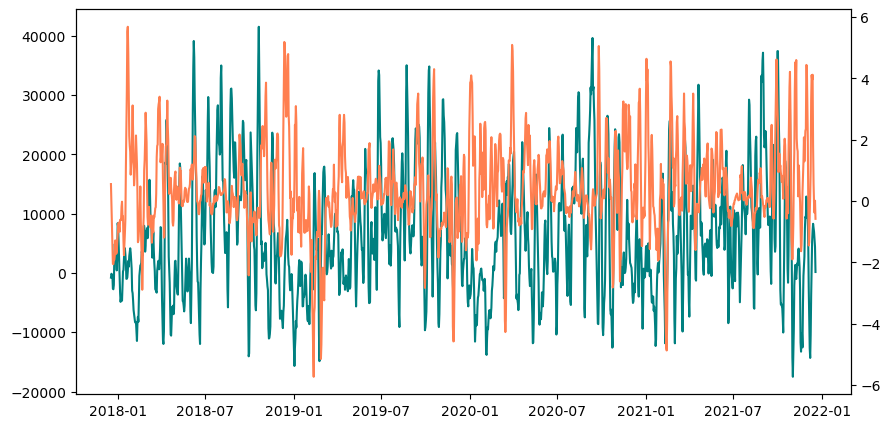

In [52]:
fig,ax = plt.subplots(figsize=(10,5))

corr,p = stats.spearmanr(winds_haro_bclin,haro_btrop)
print(corr)

ax.plot(haro_btrop,color='teal',label='Barotropic Haro')
ax2 = ax.twinx()
ax2.plot(date_haro_btrop,winds_haro_bclin,color='coral',label='Winds')

-0.052116170679746776


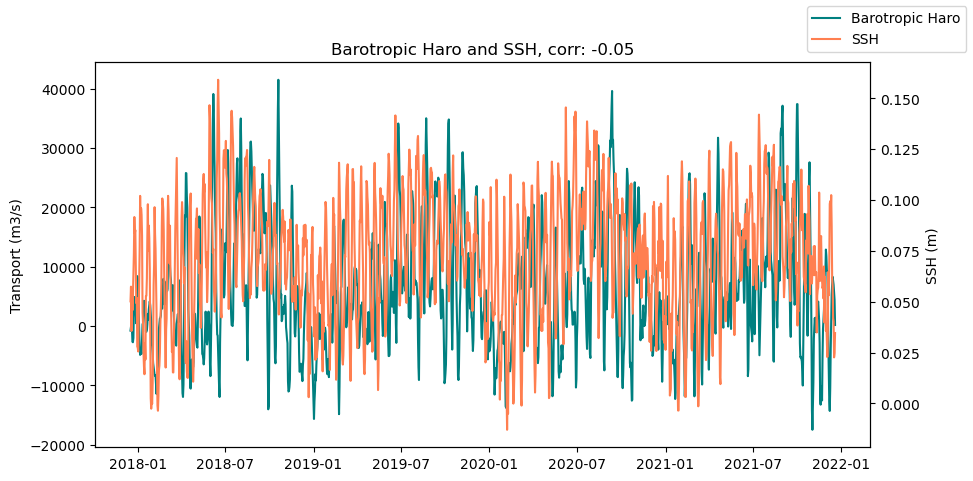

In [53]:
fig,ax = plt.subplots(figsize=(10,5))

corr,p = stats.spearmanr(ssh_haro_bclin,haro_btrop)
print(corr)

ax.plot(haro_btrop,color='teal',label='Barotropic Haro')
ax2 = ax.twinx()
ax2.plot(date_haro_btrop,ssh_haro_bclin,color='coral',label='SSH')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('SSH (m)')
ax.set_title(f'Barotropic Haro and SSH, corr: {np.round(corr,2)}')
fig.legend()

Nothing, remove tides

-0.015446298401083945


Text(0.5, 1.0, 'Barotropic haro residual and SSH, corr:-0.02')

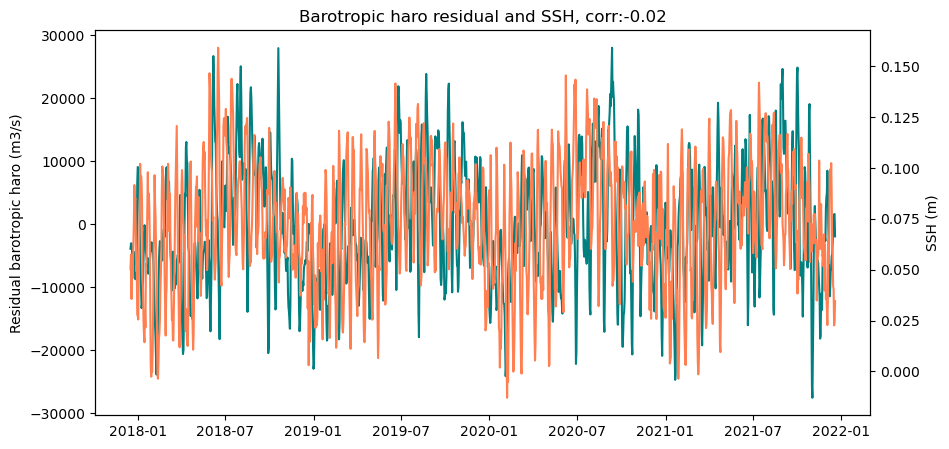

In [54]:
fig,ax = plt.subplots(figsize=(10,5))

corr,p = stats.spearmanr(ssh_haro_bclin,res_haro_btrop_tides)
print(corr)

ax.plot(date_haro_btrop,res_haro_btrop_tides,color='teal',label='Barotropic haro residual')
ax2 = ax.twinx()
ax2.plot(date_haro_btrop,ssh_haro_bclin,color='coral',label='SSH')
ax.set_ylabel('Residual barotropic haro (m3/s)')
ax2.set_ylabel('SSH (m)')
ax.set_title(f'Barotropic haro residual and SSH, corr:{np.round(corr,2)}')

0.10898225311536236


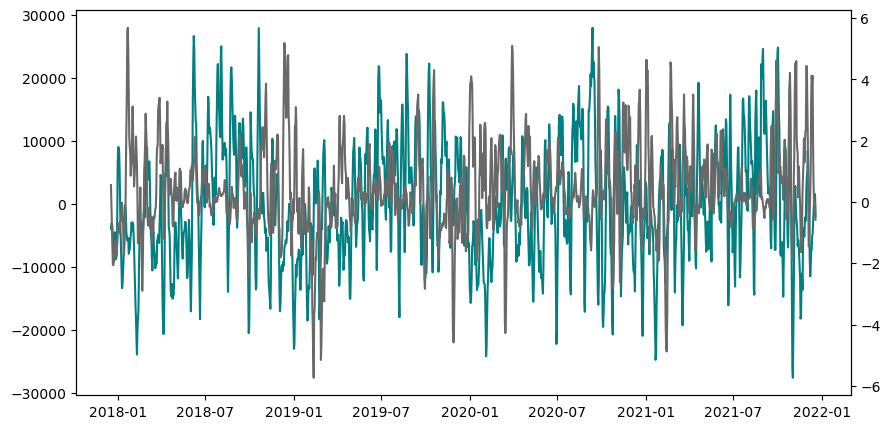

In [55]:
fig,ax = plt.subplots(figsize=(10,5))

corr,p = stats.spearmanr(winds_haro_bclin,res_haro_btrop_tides)
print(corr)

ax.plot(date_haro_btrop,res_haro_btrop_tides,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_btrop,winds_haro_bclin,color='dimgrey')

remove density difference

In [56]:
slope,intercept = np.polyfit(densdiff_haro_btrop,res_haro_btrop_tides,1)
ddline_haro_btrop = slope*densdiff_haro_btrop + intercept
res_haro_btrop_dd = res_haro_btrop_tides - ddline_haro_btrop

corr,p = stats.spearmanr(winds_haro_bclin,res_haro_btrop_dd)
print(corr)

corr,p = stats.spearmanr(ssh_haro_bclin,res_haro_btrop_dd)
print(corr)

0.19220592285932356
-0.1599827009772255


This means nothing because winds and ssh are strongly positively correlated (0.96)

Summary:
- Density difference and tides make up most of variation for baroclinic through Haro
- Other variables pretty insignficant
- Correlation b/w tides and barotropic through Haro, then small correlation with DD (nothing with other variables)

### Fraser River discharge

In [57]:
# Import data and take mean

FR_data = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/FR_discharge_16-22.csv')
FR_4mean = FR_data['Discharge (m3/s)'].rolling(window=4,center=True).mean()

date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)

dates = []
datelist_FR = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_FR.append(date)
    date += dt.timedelta(days=1)

0.4796373225042771


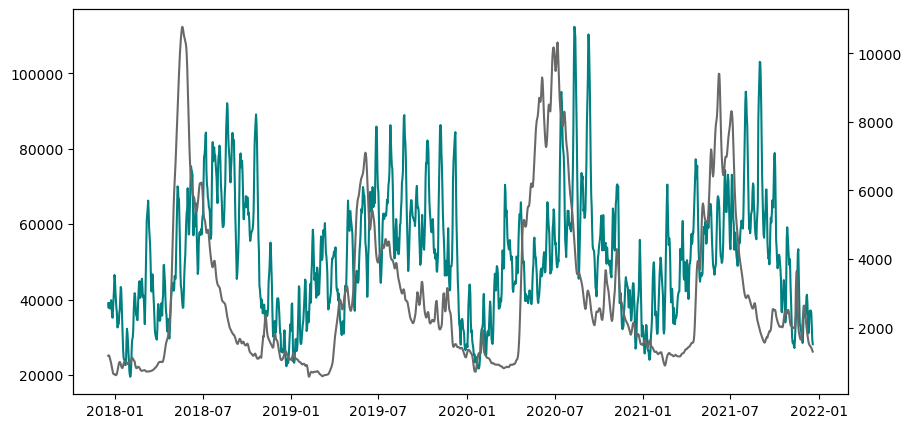

In [58]:
mask = np.isin(datelist_FR,date_haro_bclin)
FR_haro_bclin = FR_4mean[mask]

corr,p = stats.spearmanr(FR_haro_bclin,haro_bclin)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(haro_bclin,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,FR_haro_bclin,color='dimgrey')

0.1815294594946229


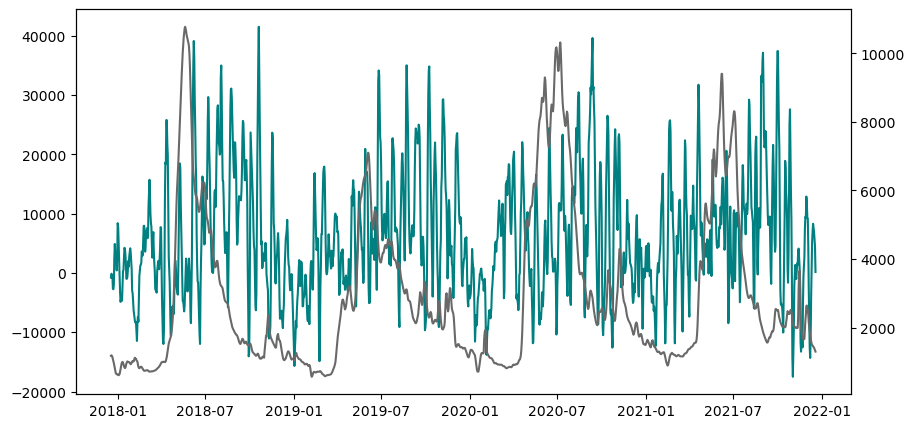

In [59]:
corr,p = stats.spearmanr(FR_haro_bclin,haro_btrop)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(haro_btrop,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,FR_haro_bclin,color='dimgrey')

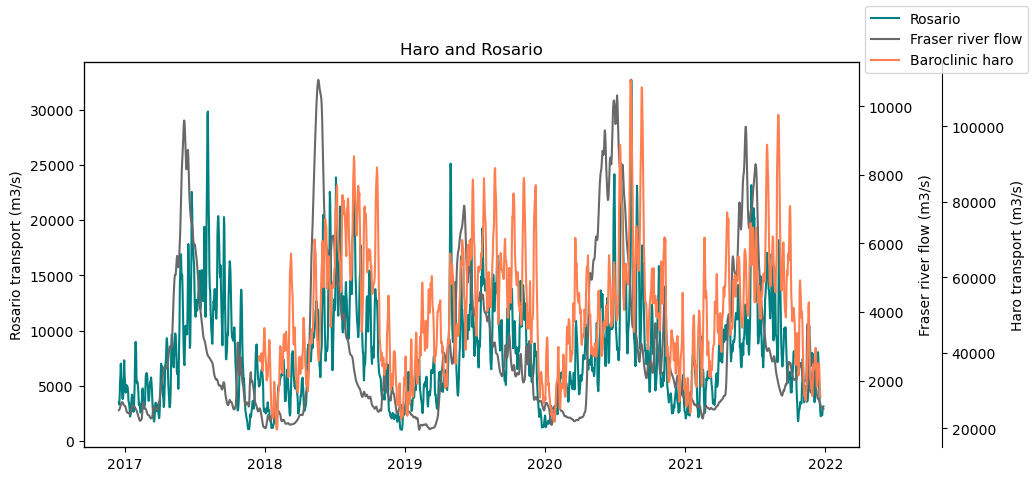

In [60]:
# Rosario and FR
mask = np.isin(datelist_FR,date_rossh)
FR_ros = FR_4mean[mask]

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(rostosouth.dropna(),color='teal',label='Rosario')
ax2 = ax.twinx()
ax2.plot(date_rossh,FR_ros,color='dimgrey',label='Fraser river flow')
ax3 = ax.twinx()
ax3.plot(haro_bclin,color='coral',label='Baroclinic haro')
ax.set_title('Haro and Rosario')
ax.set_ylabel('Rosario transport (m3/s)')
ax2.set_ylabel('Fraser river flow (m3/s)')
ax3.set_ylabel('Haro transport (m3/s)')
ax3.spines['right'].set_position(('outward', 60))
fig.legend()

Text(0.5, 1.0, 'Haro')

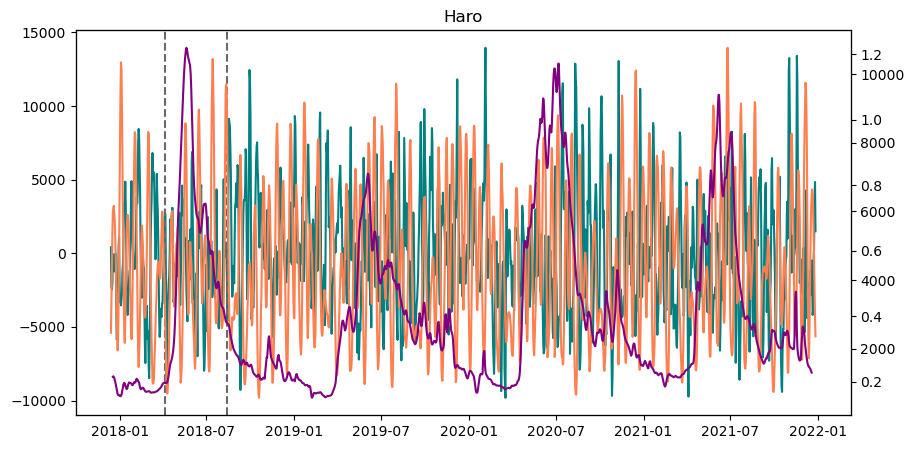

In [61]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haro2,color='teal')
ax2 = ax.twinx()
ax2.plot(date_harosh,tides_haro_sh,color='coral')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_haro_bclin,FR_haro_bclin,color='purple')
ax.axvline(date_haro_bclin[110],color='dimgrey',ls='--')
ax.axvline(date_haro_bclin[240],color='dimgrey',ls='--')
ax.set_title('Haro')

Seems to be the same time period where Fraser River discharge is higher but starts a little earlier? Look at all rivers and see if its different

Also look @ if its diff for flow to adm vs. vicsill (Rosario)

Look with 4 day mean of rostosouth

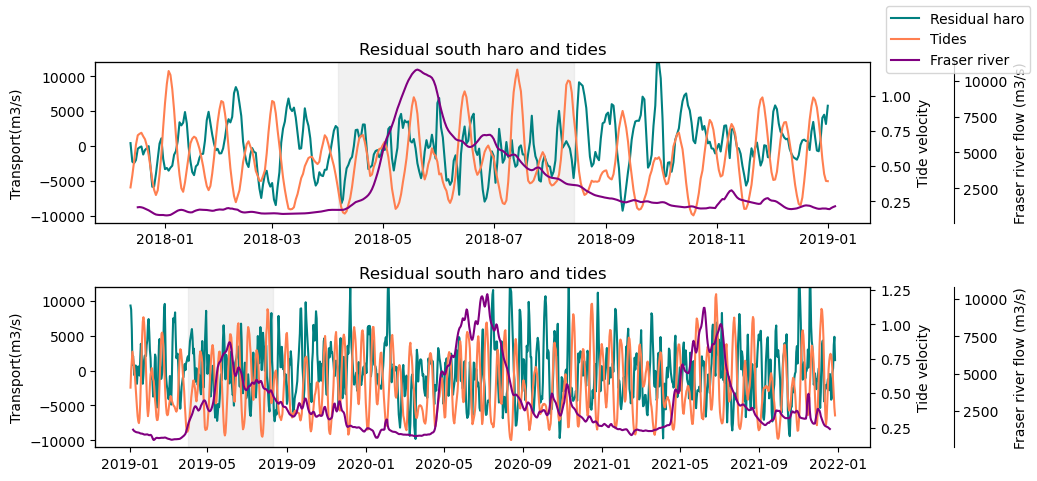

In [62]:
fig,[ax,ax4] = plt.subplots(2,1,figsize=(10,5))

ax.plot(res_haro2[0:385],color='teal',label='Residual haro')
ax2 = ax.twinx()
ax2.plot(date_harosh[0:385],tides_haro_sh[0:385],color='coral',label='Tides')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_haro_bclin[0:385],FR_haro_bclin[0:385],color='purple',label='Fraser river')
ax.set_title('Residual south haro and tides')
ax.set_ylabel('Transport(m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Fraser river flow (m3/s)')
ax.set_ylim([-11000,12000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_haro_bclin[110],x2=date_haro_bclin[240],color='lightgrey', alpha=0.3)
ax3.spines['right'].set_position(('outward', 60))
fig.legend()

ax4.plot(res_haro2[385:],color='teal',label='Residual haro')
ax42 = ax4.twinx()
ax42.plot(date_harosh[385:],tides_haro_sh[385:],color='coral',label='Tides')
ax43 = ax4.twinx()
# ax3.plot(haro_btrop,color='coral')
ax43.plot(date_haro_bclin[385:],FR_haro_bclin[385:],color='purple',label='Fraser river')
ax4.set_title('Residual south haro and tides')
ax4.set_ylabel('Transport(m3/s)')
ax42.set_ylabel('Tide velocity')
ax43.set_ylabel('Fraser river flow (m3/s)')
ax4.set_ylim([-11000,12000])
ax4.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_haro_bclin[470],x2=date_haro_bclin[600],color='lightgrey', alpha=0.3)
ax43.spines['right'].set_position(('outward', 60))

fig.subplots_adjust(hspace=0.4)

Text(0, 0.5, 'Fraser river flow (m3/s)')

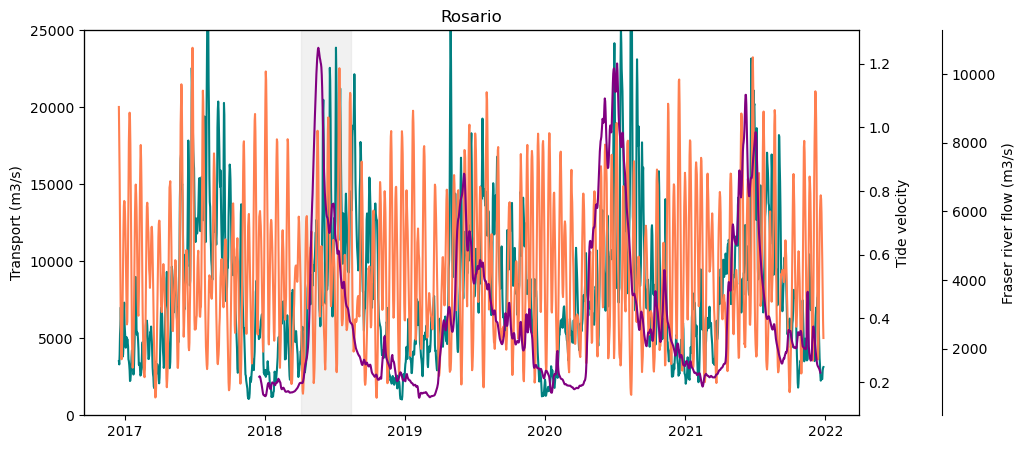

In [63]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(rostosouth.dropna(),color='teal',label='Rosario flow')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='coral',label='Tides')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_haro_bclin,FR_haro_bclin,color='purple',label='river flow')
ax.set_title('Rosario')
ax.set_ylim([0,25000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_haro_bclin[110],x2=date_haro_bclin[240],color='lightgrey', alpha=0.3)
ax3.spines['right'].set_position(('outward', 60))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Fraser river flow (m3/s)')

In [64]:
stats.spearmanr(tides_sh[110:240],rostosouth.dropna()[110:240])

SignificanceResult(statistic=0.203189993035546, pvalue=0.02041734183722139)

#### Look at timing of shift with ssh, see if its because of long-term winds

In [65]:
mask = np.isin(datelist_ssh,date_haro_bclin)
# ssh_vs_haro_bclin = ssh_vicsill[mask]
ssh_jdf_haro_bclin = ssh_jdf[mask]
# ssh_jdf7_haro_bclin = ssh_jdf7[mask]

### Look at differences in north flow

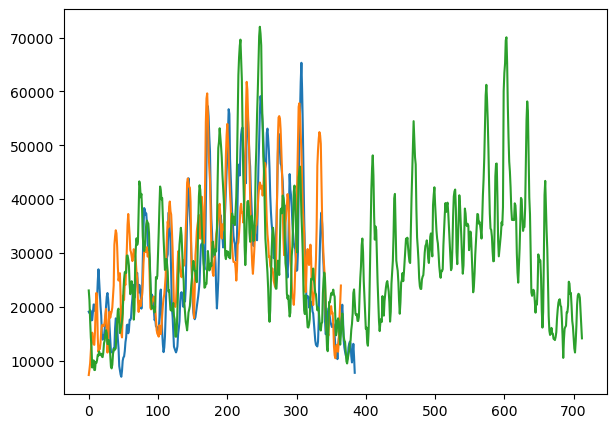

In [66]:
fig,ax = plt.subplots(figsize=(7,5))

ax.plot(np.arange(0,385),harotonorth.dropna()[0:385])
ax.plot(np.arange(0,len(harotonorth.dropna()[385:750])),harotonorth.dropna()[385:750])
ax.plot(np.arange(0,len(harotonorth.dropna()[750:])),harotonorth.dropna()[750:])

Text(0, 0.5, 'North flow through Haro')

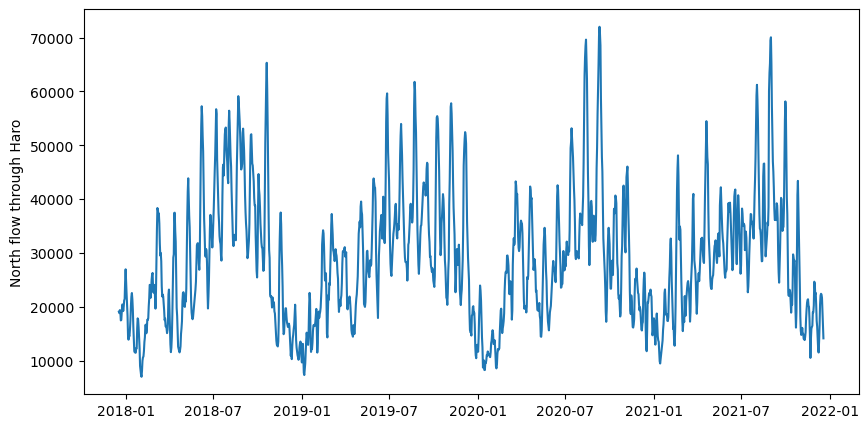

In [67]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(harotonorth.dropna())
ax.set_ylabel('North flow through Haro')

In [68]:
np.mean(harotonorth.dropna()[0:385]),np.mean(harotonorth.dropna()[385:750]),np.mean(harotonorth.dropna()[750:])

(27925.26189902926, 30249.99807939145, 28909.962193593758)

No real difference in north flow :(

### Look at differences in total baroclinic flow

Text(0, 0.5, 'Baroclinic flow through Haro')

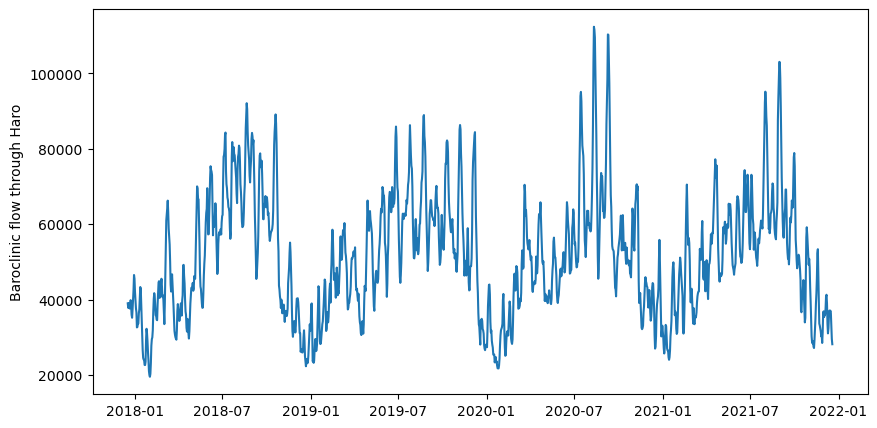

In [69]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(haro_bclin.dropna())
ax.set_ylabel('Baroclinic flow through Haro')

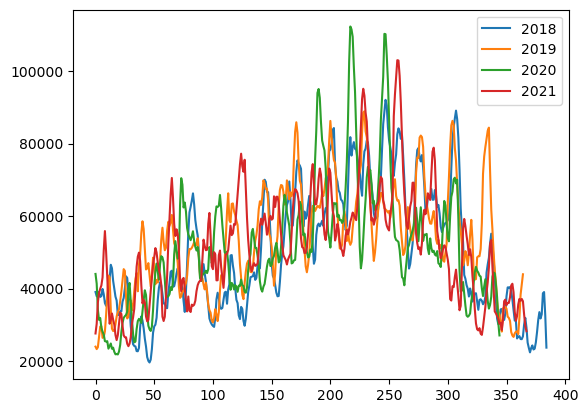

In [70]:
plt.plot(np.arange(0,385),haro_bclin[0:385],label='2018')
plt.plot(np.arange(0,len(haro_bclin[385:750])),haro_bclin[385:750],label='2019')
plt.plot(np.arange(0,len(haro_bclin[750:1095])),haro_bclin[750:1095],label='2020')
plt.plot(np.arange(0,len(haro_bclin[1095:])),haro_bclin[1095:],label='2021')
plt.legend()

#### Look at difference in total barotropic flow

Text(0, 0.5, 'Barotropic flow through Haro')

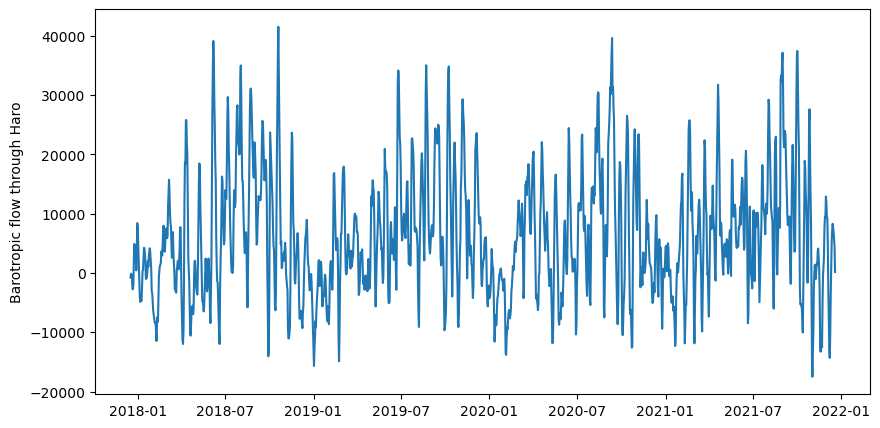

In [71]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(haro_btrop.dropna())
ax.set_ylabel('Barotropic flow through Haro')

Text(0.5, 1.0, 'Barotropic flow ')

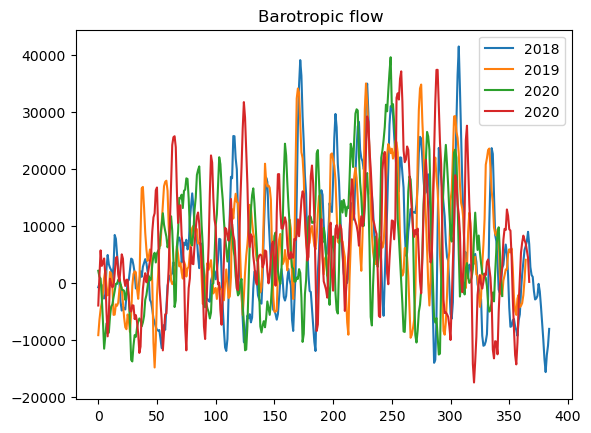

In [72]:
plt.plot(np.arange(0,385),haro_btrop[0:385],label='2018')
plt.plot(np.arange(0,len(haro_btrop[385:750])),haro_btrop[385:750],label='2019')
plt.plot(np.arange(0,len(haro_btrop[750:1095])),haro_btrop[750:1095],label='2020')
plt.plot(np.arange(0,len(haro_btrop[1095:])),haro_btrop[1095:],label='2020')
plt.legend()
plt.title('Barotropic flow ')

#### Look at baroclinic / barotropic separate for the years

In [73]:
## Calculate haro south, haro north,haro bclin, haro btrop for each

harotosouth_2018 = PRtovs2018_haro_avg.dropna() + Gulftovs2018_haro_avg.dropna()
harotosouth_2019 = PRtovs2019_haro_avg.dropna() + Gulftovs2019_haro_avg.dropna()
harotosouth_2020 = PRtovs2020_haro_avg.dropna() + Gulftovs2020_haro_avg.dropna()
harotosouth_2021 = PRtovs2021_haro_avg.dropna() + Gulftovs2021_haro_avg.dropna()

harotonorth_2018 = VStogulf2018_haro_avg.dropna() + VStoPR2018_haro_avg.dropna()
harotonorth_2019 = VStogulf2019_haro_avg.dropna() + VStoPR2019_haro_avg.dropna()
harotonorth_2020 = VStogulf2020_haro_avg.dropna() + VStoPR2020_haro_avg.dropna()
harotonorth_2021 = VStogulf2021_haro_avg.dropna() + VStoPR2021_haro_avg.dropna()

haro_bclin2018 = (harotosouth_2018 + harotonorth_2018).dropna()
haro_bclin2019 = (harotosouth_2019 + harotonorth_2019).dropna()
haro_bclin2020 = (harotosouth_2020 + harotonorth_2020).dropna()
haro_bclin2021 = (harotosouth_2021 + harotonorth_2021).dropna()

haro_btrop2018 = (-harotosouth_2018 + harotonorth_2018).dropna()
haro_btrop2019 = (-harotosouth_2019 + harotonorth_2019).dropna()
haro_btrop2020 = (-harotosouth_2020 + harotonorth_2020).dropna()
haro_btrop2021 = (-harotosouth_2021 + harotonorth_2021).dropna()

date_haro2018 = list(haro_bclin2018.index)
date_haro2019 = list(haro_bclin2019.index)
date_haro2020 = list(haro_bclin2020.index)
date_haro2021 = list(haro_bclin2021.index)

# Calculate correlation with density difference, residual and corr with tides
#2018
mask = np.isin(datelist_dens,date_haro2018)
densdiff_haro_bclin2018 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_bclin2018,haro_bclin2018)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_bclin2018,haro_bclin2018,1)
ddlin_haro_bclin2018 = slope*densdiff_haro_bclin2018+intercept
res_haro_bclin2018 = haro_bclin2018 - ddlin_haro_bclin2018
mask = np.isin(datelist_tides,date_haro2018)
tides_haro_bclin2018 = tides[mask]

#2019
mask = np.isin(datelist_dens,date_haro2019)
densdiff_haro_bclin2019 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_bclin2019,haro_bclin2019)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_bclin2019,haro_bclin2019,1)
ddlin_haro_bclin2019 = slope*densdiff_haro_bclin2019+intercept
res_haro_bclin2019 = haro_bclin2019 - ddlin_haro_bclin2019
mask = np.isin(datelist_tides,date_haro2019)
tides_haro_bclin2019 = tides[mask]

#2020
mask = np.isin(datelist_dens,date_haro2020)
densdiff_haro_bclin2020 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_bclin2020,haro_bclin2020)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_bclin2020,haro_bclin2020,1)
ddlin_haro_bclin2020 = slope*densdiff_haro_bclin2020+intercept
res_haro_bclin2020 = haro_bclin2020 - ddlin_haro_bclin2020
mask = np.isin(datelist_tides,date_haro2020)
tides_haro_bclin2020 = tides[mask]

#2021
mask = np.isin(datelist_dens,date_haro2021)
densdiff_haro_bclin2021 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_bclin2021,haro_bclin2021)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_bclin2021,haro_bclin2021,1)
ddlin_haro_bclin2021 = slope*densdiff_haro_bclin2021+intercept
res_haro_bclin2021 = haro_bclin2021 - ddlin_haro_bclin2021
mask = np.isin(datelist_tides,date_haro2021)
tides_haro_bclin2021 = tides[mask]

#Btrop
#2018
mask = np.isin(datelist_dens,date_haro2018)
densdiff_haro_btrop2018 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_btrop2018,haro_btrop2018)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_btrop2018,haro_bclin2018,1)
ddlin_haro_btrop2018 = slope*densdiff_haro_btrop2018+intercept
res_haro_btrop2018 = haro_btrop2018 - ddlin_haro_btrop2018
mask = np.isin(datelist_tides,date_haro2018)
tides_haro_btrop2018 = tides[mask]

#2019
mask = np.isin(datelist_dens,date_haro2019)
densdiff_haro_btrop2019 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_btrop2019,haro_btrop2019)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_btrop2019,haro_btrop2019,1)
ddlin_haro_btrop2019 = slope*densdiff_haro_btrop2019+intercept
res_haro_btrop2019 = haro_btrop2019 - ddlin_haro_btrop2019
mask = np.isin(datelist_tides,date_haro2019)
tides_haro_btrop2019 = tides[mask]

#2020
mask = np.isin(datelist_dens,date_haro2020)
densdiff_haro_btrop2020 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_btrop2020,haro_btrop2020)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_btrop2020,haro_btrop2020,1)
ddlin_haro_btrop2020 = slope*densdiff_haro_btrop2020+intercept
res_haro_btrop2020 = haro_btrop2020 - ddlin_haro_btrop2020
mask = np.isin(datelist_tides,date_haro2020)
tides_haro_btrop2020 = tides[mask]

#2021
mask = np.isin(datelist_dens,date_haro2021)
densdiff_haro_btrop2021 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_btrop2021,haro_btrop2021)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_btrop2021,haro_btrop2021,1)
ddlin_haro_btrop2021 = slope*densdiff_haro_btrop2021+intercept
res_haro_btrop2021 = haro_btrop2021 - ddlin_haro_btrop2021
mask = np.isin(datelist_tides,date_haro2021)
tides_haro_btrop2021 = tides[mask]

slope,intercept = np.polyfit(densdiff_haro_btrop,haro_btrop,1)
res_haro_btrop = haro_btrop - (slope*densdiff_haro_btrop+intercept)


0.8393221937940344
0.7202436766884357
0.7529608478674692
0.7811203639225115
0.3519328557086722
0.3057712668194254
0.25263884223237065
0.21697906944713333


In [74]:
corr_2018,p = stats.spearmanr(tides_haro_bclin2018,res_haro_bclin2018)
print(corr_2018)
corr_2019,p = stats.spearmanr(tides_haro_bclin2019,res_haro_bclin2019)
print(corr_2019)
corr_2020,p = stats.spearmanr(tides_haro_bclin2020,res_haro_bclin2020)
print(corr_2020)
corr_2021,p = stats.spearmanr(tides_haro_bclin2021,res_haro_bclin2021)
print(corr_2021)

-0.6348249855665014
-0.6836877711523602
-0.6514452423970052
-0.6336373084143115


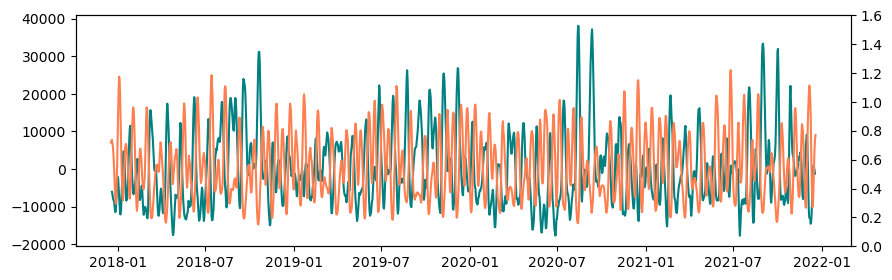

In [75]:
res_haro_bclin_4d = res_haro_bclin.rolling(4, center=True).mean()

fig,ax = plt.subplots(figsize=(10,3))
ax.plot(res_haro_bclin_4d,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,tides_haro_bclin,color='coral')
ax2.set_ylim([0,1.6])

slope,intercept = np.polyfit(tides_haro_bclin,res_haro_bclin,1)
line_res_tides = slope*tides_haro_bclin+intercept

slope,intercept = np.polyfit(densdiff_haro_bclin,haro_bclin,1)
line_bclin_dd = slope*densdiff_haro_bclin+intercept

-0.6367412347905815
0.7977244510764375
-0.6514452423970052
0.7529608478674692


/tmp/ipykernel_31549/1491491282.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.arange(0,120000,20000),color=color1)
/tmp/ipykernel_31549/1491491282.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax12.set_yticklabels(np.arange(4,15,2),color=color2)
/tmp/ipykernel_31549/1491491282.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(np.arange(-25000,46000,10000),color=color3)
/tmp/ipykernel_31549/1491491282.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)


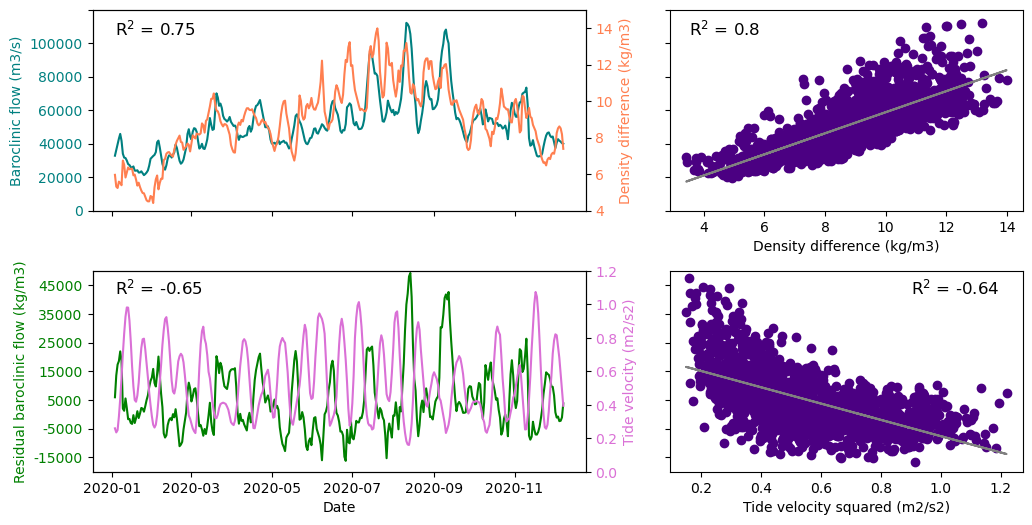

In [76]:
color1 = 'teal'
color2 = 'coral'
color3 = 'green'
color4 = 'orchid'

corr_tides_res,p = stats.spearmanr(tides_haro_bclin,res_haro_bclin.dropna())
print(corr_tides_res)

corr_bclin_dd,p = stats.spearmanr(densdiff_haro_bclin,haro_bclin.dropna())
print(corr_bclin_dd)

corr_tides_res_2020,p = stats.spearmanr(tides_haro_bclin2020,res_haro_bclin2020.dropna())
print(corr_tides_res_2020)

corr_bclin_dd_2020,p = stats.spearmanr(densdiff_haro_bclin2020,haro_bclin2020.dropna())
print(corr_bclin_dd_2020)

fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(12,6),gridspec_kw={'width_ratios':[1.4,1]})
ax1.plot(haro_bclin2020,color=color1)
ax1.set_xticklabels([])
ax12 = ax1.twinx()
ax12.plot(date_haro2020,densdiff_haro_bclin2020,color=color2)
ax1.set_ylim([0,120000])
ax1.set_ylabel('Baroclinic flow (m3/s)',color=color1)
ax1.set_yticklabels(np.arange(0,120000,20000),color=color1)
ax12.set_ylabel('Density difference (kg/m3)',color=color2)
ax12.set_ylim([4,15])
ax12.set_yticklabels(np.arange(4,15,2),color=color2)
ax1.annotate(f'R$^2$ = {np.round(corr_bclin_dd_2020,2)}',(date_haro2020[0],105000),fontsize=12)

ax2.scatter(densdiff_haro_bclin,haro_bclin,color='indigo')
ax2.plot(densdiff_haro_bclin,line_bclin_dd,color='grey')
ax2.set_ylim([0,120000])
ax2.set_yticklabels([])
ax2.set_xlabel('Density difference (kg/m3)')
ax2.annotate(f'R$^2$ = {np.round(corr_bclin_dd,2)}',(3.5,105000),fontsize=12)

ax3.plot(res_haro_bclin2020,color=color3)
ax32 = ax3.twinx()
ax32.plot(date_haro2020,tides_haro_bclin2020,color=color4)
ax3.set_ylim([-25000,45000])
ax3.set_xlabel('Date')
ax3.set_ylabel('Residual baroclinic flow (kg/m3)',color=color3)
ax32.set_ylabel('Tide velocity (m2/s2)',color=color4)
ax3.set_yticklabels(np.arange(-25000,46000,10000),color=color3)
ax32.set_ylim([0,1.2])
ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)
ax32.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{1}f}}'))
ax3.annotate(f'R$^2$ = {np.round(corr_tides_res_2020,2)}',(date_haro2020[0],37000),fontsize=12)

ax4.scatter(tides_haro_bclin,res_haro_bclin.dropna(),color='indigo')
ax4.plot(tides_haro_bclin,line_res_tides,color='grey')
ax4.set_ylim([-25000,45000])
ax4.set_yticklabels([])
ax4.set_xlabel('Tide velocity squared (m2/s2)')
ax4.annotate(f'R$^2$ = {np.round(corr_tides_res,2)}',(0.9,37000),fontsize=12)

fig.subplots_adjust(wspace=0.2,hspace=0.3)

In [77]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/baroclinic_correlations.png',bbox_inches='tight')

### Check how 2 years looks

In [78]:
mask = np.logical_or(haro_bclin.index.year == 2019,haro_bclin.index.year==2020)
date_haro_1920 = haro_bclin.index[mask]
haro_bclin_1920 = haro_bclin[mask]

mask = np.isin(pd.to_datetime(datelist_dens),date_haro_1920)
densdiff_haro_bclin1920 = dens_diff_vspr[mask]

mask = np.isin(pd.to_datetime(datelist_tides),date_haro_1920)
tides_haro_bclin1920 = tides[mask]

slope,intercept = np.polyfit(densdiff_haro_bclin1920,haro_bclin_1920,1)
ddline_1920 = slope*densdiff_haro_bclin1920+intercept
res_haro_bclin1920 = haro_bclin_1920 - ddline_1920

slope,intercept = np.polyfit(tides_haro_bclin1920,res_haro_bclin1920,1)
tline_1920 = slope*tides_haro_bclin1920+intercept

-0.640808411432252
0.7665745959674128
-0.6514452423970052
0.7529608478674692


/tmp/ipykernel_31549/2101871186.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.arange(0,120000,20000),color=color1)
/tmp/ipykernel_31549/2101871186.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax12.set_yticklabels(np.arange(4,15,2),color=color2)
/tmp/ipykernel_31549/2101871186.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(np.arange(-25000,46000,10000),color=color3)
/tmp/ipykernel_31549/2101871186.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)


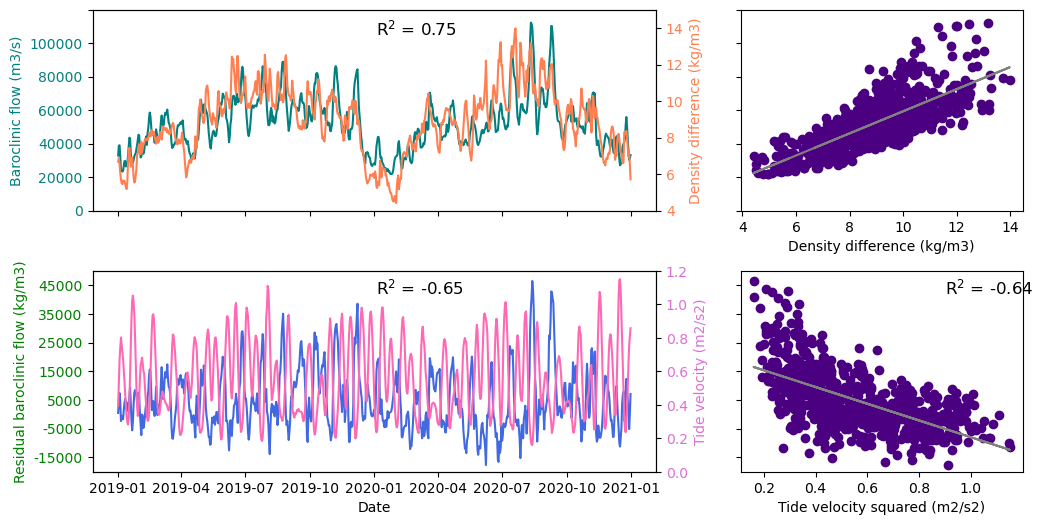

In [79]:
corr_tides_res,p = stats.spearmanr(tides_haro_bclin1920,res_haro_bclin1920.dropna())
print(corr_tides_res)

corr_bclin_dd,p = stats.spearmanr(densdiff_haro_bclin1920,haro_bclin_1920.dropna())
print(corr_bclin_dd)

corr_tides_res_2020,p = stats.spearmanr(tides_haro_bclin2020,res_haro_bclin2020.dropna())
print(corr_tides_res_2020)

corr_bclin_dd_2020,p = stats.spearmanr(densdiff_haro_bclin2020,haro_bclin2020.dropna())
print(corr_bclin_dd_2020)

fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(12,6),gridspec_kw={'width_ratios':[2,1]})
ax1.plot(haro_bclin_1920,color=color1)
ax1.set_xticklabels([])
ax12 = ax1.twinx()
ax12.plot(date_haro_1920,densdiff_haro_bclin1920,color=color2)
ax1.set_ylim([0,120000])
ax1.set_ylabel('Baroclinic flow (m3/s)',color=color1)
ax1.set_yticklabels(np.arange(0,120000,20000),color=color1)
ax12.set_ylabel('Density difference (kg/m3)',color=color2)
ax12.set_ylim([4,15])
ax12.set_yticklabels(np.arange(4,15,2),color=color2)
ax1.annotate(f'R$^2$ = {np.round(corr_bclin_dd_2020,2)}',(date_haro2020[0],105000),fontsize=12)

ax2.scatter(densdiff_haro_bclin1920,haro_bclin_1920,color='indigo')
ax2.plot(densdiff_haro_bclin1920,ddline_1920,color='grey')
ax2.set_ylim([0,120000])
ax2.set_yticklabels([])
ax2.set_xlabel('Density difference (kg/m3)')
ax2.annotate(f'R$^2$ = {np.round(corr_bclin_dd,2)}',(3.5,105000),fontsize=12)

ax3.plot(res_haro_bclin1920,color='royalblue')
ax32 = ax3.twinx()
ax32.plot(date_haro_1920,tides_haro_bclin1920,color='hotpink')
ax3.set_ylim([-25000,45000])
ax3.set_xlabel('Date')
ax3.set_ylabel('Residual baroclinic flow (kg/m3)',color=color3)
ax32.set_ylabel('Tide velocity (m2/s2)',color=color4)
ax3.set_yticklabels(np.arange(-25000,46000,10000),color=color3)
ax32.set_ylim([0,1.2])
ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)
ax32.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{1}f}}'))
ax3.annotate(f'R$^2$ = {np.round(corr_tides_res_2020,2)}',(date_haro2020[0],37000),fontsize=12)

ax4.scatter(tides_haro_bclin1920,res_haro_bclin1920.dropna(),color='indigo')
ax4.plot(tides_haro_bclin1920,tline_1920,color='grey')
ax4.set_ylim([-25000,45000])
ax4.set_yticklabels([])
ax4.set_xlabel('Tide velocity squared (m2/s2)')
ax4.annotate(f'R$^2$ = {np.round(corr_tides_res,2)}',(0.9,37000),fontsize=12)

fig.subplots_adjust(wspace=0.2,hspace=0.3)

#### Make plot with barotropic

In [80]:
corr_2018,p = stats.spearmanr(tides_haro_btrop2018,haro_btrop2018)
print(corr_2018)
corr_2019,p = stats.spearmanr(tides_haro_btrop2019,haro_btrop2019)
print(corr_2019)
corr_2020,p = stats.spearmanr(tides_haro_btrop2020,haro_btrop2020)
print(corr_2020)

-0.4629587600199919
-0.46057463939900195
-0.3726395080334958


-0.41124052187058774
0.30757648467234666
-0.3726395080334958
0.25263884223237065


/tmp/ipykernel_31549/3076074232.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.arange(-20000,45000,10000),color=color1)
/tmp/ipykernel_31549/3076074232.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax12.set_yticklabels(np.arange(4,15,2),color=color2)
/tmp/ipykernel_31549/3076074232.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(np.arange(-20000,45000,10000),color=color3)
/tmp/ipykernel_31549/3076074232.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)


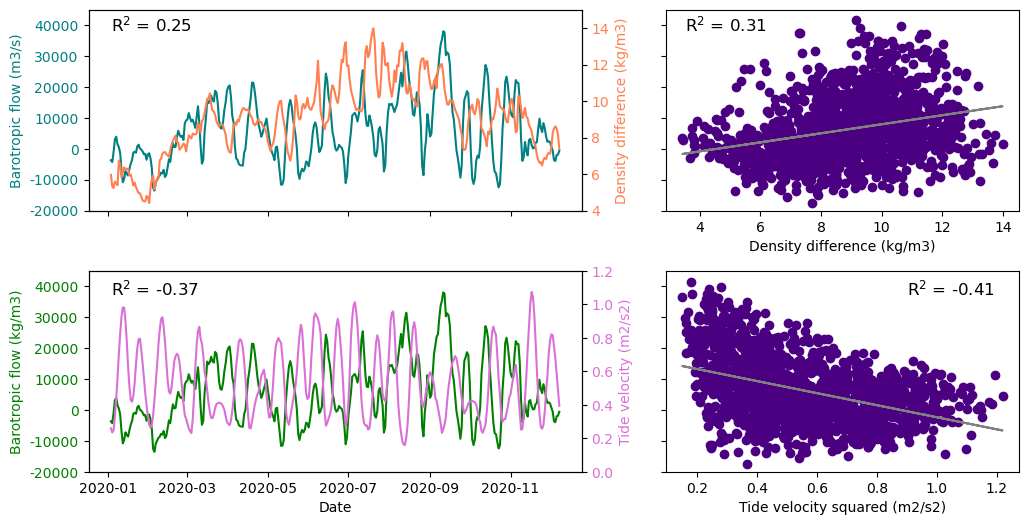

In [81]:
corr_btrop_tides,p = stats.spearmanr(tides_haro_btrop,haro_btrop)
print(corr_btrop_tides)

corr_btrop_dd,p = stats.spearmanr(densdiff_haro_btrop,haro_btrop.dropna())
print(corr_btrop_dd)

corr_btrop_tides_2020,p = stats.spearmanr(tides_haro_btrop2020,haro_btrop2020)
print(corr_btrop_tides_2020)

corr_btrop_dd_2020,p = stats.spearmanr(densdiff_haro_btrop2020,haro_btrop2020.dropna())
print(corr_btrop_dd_2020)

slope,intercept = np.polyfit(tides_haro_btrop,haro_btrop,1)
line_btrop_tides = slope*tides_haro_btrop+intercept

slope,intercept = np.polyfit(densdiff_haro_btrop,haro_btrop,1)
line_btrop_dd = slope*densdiff_haro_btrop+intercept

fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(12,6),gridspec_kw={'width_ratios':[1.4,1]})
ax1.plot(haro_btrop2020,color=color1)
ax1.set_xticklabels([])
ax12 = ax1.twinx()
ax12.plot(date_haro2020,densdiff_haro_btrop2020,color=color2)
ax1.set_ylim([-20000,45000])
ax1.set_ylabel('Barotropic flow (m3/s)',color=color1)
ax1.set_yticklabels(np.arange(-20000,45000,10000),color=color1)
ax12.set_ylabel('Density difference (kg/m3)',color=color2)
ax12.set_ylim([4,15])
ax12.set_yticklabels(np.arange(4,15,2),color=color2)
ax1.annotate(f'R$^2$ = {np.round(corr_btrop_dd_2020,2)}',(date_haro2020[0],38000),fontsize=12)

ax2.scatter(densdiff_haro_btrop,haro_btrop,color='indigo')
ax2.plot(densdiff_haro_btrop,line_btrop_dd,color='grey')
ax2.set_ylim([-20000,45000])
ax2.set_yticks(np.arange(-20000,45000,10000))
ax2.set_yticklabels([])
ax2.set_xlabel('Density difference (kg/m3)')
ax2.annotate(f'R$^2$ = {np.round(corr_btrop_dd,2)}',(3.5,38000),fontsize=12)

ax3.plot(haro_btrop2020,color=color3)
ax32 = ax3.twinx()
ax32.plot(date_haro2020,tides_haro_btrop2020,color=color4)
ax3.set_ylim([-20000,45000])
ax3.set_xlabel('Date')
ax3.set_ylabel('Barotropic flow (kg/m3)',color=color3)
ax32.set_ylabel('Tide velocity (m2/s2)',color=color4)
ax3.set_yticklabels(np.arange(-20000,45000,10000),color=color3)
ax32.set_ylim([0,1.2])
ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)
ax32.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{1}f}}'))
ax3.annotate(f'R$^2$ = {np.round(corr_btrop_tides_2020,2)}',(date_haro2020[0],37000),fontsize=12)

ax4.scatter(tides_haro_btrop,haro_btrop,color='indigo')
ax4.plot(tides_haro_btrop,line_btrop_tides,color='grey')
ax4.set_ylim([-20000,45000])
ax4.set_yticklabels([])
ax4.set_xlabel('Tide velocity squared (m2/s2)')
ax4.annotate(f'R$^2$ = {np.round(corr_btrop_tides,2)}',(0.9,37000),fontsize=12)

fig.subplots_adjust(wspace=0.2,hspace=0.3);

In [82]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/barotropic_correlations.png',bbox_inches='tight')

-0.3726395080334958
0.3726395080334958


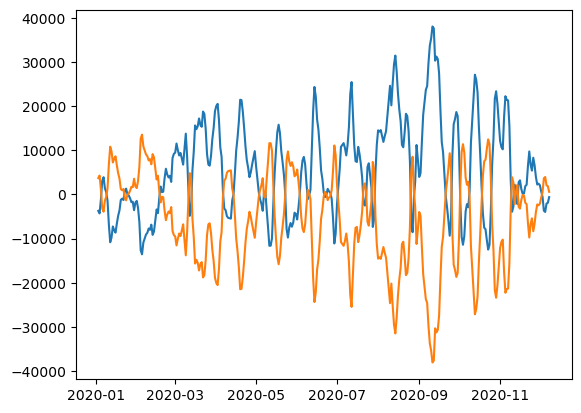

In [83]:
haro_btrop2020_2 = (harotosouth_2020 - harotonorth_2020).dropna()

fig,ax = plt.subplots()
ax.plot(haro_btrop2020)
ax.plot(haro_btrop2020_2)

corr_2020,p = stats.spearmanr(tides_haro_btrop2020,haro_btrop2020)
print(corr_2020)
corr_2020,p = stats.spearmanr(tides_haro_btrop2020,haro_btrop2020_2)
print(corr_2020)

Artbitrary so how to pick? I would assume pick the one that is positive most often??

### Rosario correlation plots

#### Import puget river data

In [84]:
#Import puget river data
pugetr_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/puget_rivers_avg.csv')
datelist_pugetr = pd.to_datetime(pugetr_df['Date'])
pugetr = pd.DataFrame({'discharge(kg/m2/s)':pugetr_df['0'].values},index=datelist_pugetr)['discharge(kg/m2/s)'].rolling(window=4,center=True).mean().dropna()
datelist_pugetr = pd.to_datetime(pugetr.index)

In [85]:
mask = np.logical_or(datelist_rostosouth.dt.year==2019,datelist_rostosouth.dt.year==2020)
date_rostosouth_1920 = datelist_rostosouth[mask]
mask.index = rostosouth.index
rostosouth_1920 = rostosouth[mask]

mask = np.isin(pd.to_datetime(datelist_dens),date_rostosouth_1920)
densdiff_ros1920 = dens_diff_vspr[mask]

slope,intercept = np.polyfit(densdiff_ros1920,rostosouth_1920,1)
ddline_ros1920 = slope*densdiff_ros1920+intercept
res_rostosouth1920 = rostosouth_1920-ddline_ros1920

mask = np.isin(pd.to_datetime(datelist_tides),date_rostosouth_1920)
tides_ros1920 = tides[mask]

In [86]:
corr_ros_dd,p = stats.spearmanr(densdiff_ros1920,rostosouth_1920)
print(corr_ros_dd)
corr_ros_res,p = stats.spearmanr(tides_ros1920,res_rostosouth1920)
print(corr_ros_res)

0.819927911001145
-0.22123660926724262


In [87]:
mask = np.isin(datelist_pugetr,date_rostosouth_1920)
pugetr_1920 = pugetr[mask]

corr_res_puget,p = stats.spearmanr(pugetr_1920,res_rostosouth1920)
print(corr_res_puget)

0.0464660999532125


In [88]:
mask = np.isin(pd.to_datetime(datelist_tides),datelist_rostosouth)
tides_ros = tides[mask]

stats.spearmanr(tides_ros,rostosouth)

SignificanceResult(statistic=-0.10771975141856657, pvalue=3.6835594696800493e-06)

In [89]:
mask = np.logical_or(datelist_rostosouth.dt.year==2019,datelist_rostosouth.dt.year==2020)
date_rostosouth_1920 = datelist_rostosouth[mask]
mask.index = rostosouth.index
rostosouth_1920 = rostosouth[mask]

mask = np.isin(pd.to_datetime(datelist_dens),date_rostosouth_1920)
densdiff_ros1920 = dens_diff_vspr[mask]

slope,intercept = np.polyfit(densdiff_ros1920,rostosouth_1920,1)
ddline_ros1920 = slope*densdiff_ros1920+intercept
res_rostosouth1920 = rostosouth_1920-ddline_ros1920

mask = np.isin(pd.to_datetime(datelist_tides),date_rostosouth_1920)
tides_ros1920 = tides[mask]

### Plot just one year

In [90]:
mask = np.isin(pd.to_datetime(datelist_dens),datelist_rostosouth_2020)
densdiff_ros2020 = dens_diff_vspr[mask]

slope,intercept = np.polyfit(densdiff_ros2020,rostosouth_2020,1)
ddline_ros2020 = slope*densdiff_ros2020+intercept
res_ros2020 = rostosouth_2020 - ddline_ros2020

mask = np.isin(pd.to_datetime(datelist_tides),datelist_rostosouth_2020)
tides_ros2020 = tides[mask]

## Get puget rivers in 2020
mask = np.isin(datelist_pugetr,datelist_rostosouth_2020)
pugetr_2020 = pugetr[mask]

#2018
mask = np.isin(pd.to_datetime(datelist_dens),datelist_rostosouth_2018)
densdiff_ros2018 = dens_diff_vspr[mask]

slope,intercept = np.polyfit(densdiff_ros2018,rostosouth_2018,1)
ddline_ros2018 = slope*densdiff_ros2018+intercept
res_ros2018 = rostosouth_2018 - ddline_ros2018

mask = np.isin(pd.to_datetime(datelist_tides),datelist_rostosouth_2018)
tides_ros2018 = tides[mask]

#2019
mask = np.isin(pd.to_datetime(datelist_dens),datelist_rostosouth_2019)
densdiff_ros2019 = dens_diff_vspr[mask]

slope,intercept = np.polyfit(densdiff_ros2019,rostosouth_2019,1)
ddline_ros2019 = slope*densdiff_ros2019+intercept
res_ros2019 = rostosouth_2019 - ddline_ros2019

mask = np.isin(pd.to_datetime(datelist_tides),datelist_rostosouth_2019)
tides_ros2019 = tides[mask]

#2021
mask = np.isin(pd.to_datetime(datelist_dens),datelist_rostosouth_2021)
densdiff_ros2021 = dens_diff_vspr[mask]

slope,intercept = np.polyfit(densdiff_ros2021,rostosouth_2021,1)
ddline_ros2021 = slope*densdiff_ros2021+intercept
res_ros2021 = rostosouth_2021 - ddline_ros2021

mask = np.isin(pd.to_datetime(datelist_tides),datelist_rostosouth_2021)
tides_ros2021 = tides[mask]

In [91]:
#Calculate for all years
mask = np.isin(pd.to_datetime(datelist_dens),datelist_rostosouth[365:])
densdiff_ros = dens_diff_vspr[mask]

slope,intercept = np.polyfit(densdiff_ros,rostosouth[365:],1)
ddline_ros = slope*densdiff_ros+intercept
res_ros = rostosouth[365:] - ddline_ros

mask = np.isin(pd.to_datetime(datelist_tides),datelist_rostosouth[365:])
tides_ros = tides[mask]

slope,intercept = np.polyfit(tides_ros,res_ros,1)
tline_ros = tides_ros*slope+intercept

## Get puget rivers 
mask = np.isin(datelist_pugetr,datelist_rostosouth[365:])
pugetr_ros = pugetr[mask]


### Winds and rosario

In [92]:
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2018)
winds_ros2018 = y_mean4[mask]
corr_winds_resros2018,p = stats.spearmanr(np.abs(winds_ros2018),res_ros2018)
print(corr_winds_resros2018)
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2019)
winds_ros2019 = y_mean4[mask]
corr_winds_resros2019,p = stats.spearmanr(np.abs(winds_ros2019),res_ros2019)
print(corr_winds_resros2019)
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2020)
winds_ros2020 = y_mean4[mask]
corr_winds_resros2020,p = stats.spearmanr(np.abs(winds_ros2020),res_ros2020)
print(corr_winds_resros2020)
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2021)
winds_ros2021 = y_mean4[mask]
corr_winds_resros2021,p = stats.spearmanr(np.abs(winds_ros2021),res_ros2021)
print(corr_winds_resros2021)

mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2018)
winds_ros2018 = y_mean4_rr[mask]
corr_winds_rr_resros2018,p = stats.spearmanr(winds_ros2018,res_ros2018)
print('RR:',corr_winds_rr_resros2018)
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2019)
winds_ros2019 = y_mean4_rr[mask]
corr_winds_rr_resros2019,p = stats.spearmanr(winds_ros2019,res_ros2019)
print(corr_winds_rr_resros2019)
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2020)
winds_ros2020 = y_mean4_rr[mask]
corr_winds_rr_resros2020,p = stats.spearmanr(winds_ros2020,res_ros2020)
print(corr_winds_rr_resros2020)
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2021)
winds_ros2021 = y_mean4_rr[mask]
corr_winds_rr_resros2021,p = stats.spearmanr(winds_ros2021,res_ros2021)
print(corr_winds_rr_resros2021)

corr_ros_res2018,p = stats.spearmanr(tides_ros2018,res_ros2018)
print(corr_ros_res2018)
corr_ros_res2019,p = stats.spearmanr(tides_ros2019,res_ros2019)
print(corr_ros_res2019)
corr_ros_res2020,p = stats.spearmanr(tides_ros2020,res_ros2020)
print(corr_ros_res2020)
corr_ros_res2021,p = stats.spearmanr(tides_ros2021,res_ros2021)
print(corr_ros_res2021)

mask = np.isin(pd.to_datetime(datelist_ssh),datelist_rostosouth_2018)
ssh_ros2018 = ssh_jdf[mask]
corr_ssh_resros2018,p = stats.spearmanr(ssh_ros2018,res_ros2018)
print('SSH:',corr_ssh_resros2018)
mask = np.isin(pd.to_datetime(datelist_ssh),datelist_rostosouth_2019)
ssh_ros2019 = ssh_jdf[mask]
corr_ssh_resros2019,p = stats.spearmanr(ssh_ros2019,res_ros2019)
print(corr_ssh_resros2019)
mask = np.isin(pd.to_datetime(datelist_ssh),datelist_rostosouth_2020)
ssh_ros2020 = ssh_jdf[mask]
corr_ssh_resros2020,p = stats.spearmanr(ssh_ros2020,res_ros2020)
print(corr_ssh_resros2020)
mask = np.isin(pd.to_datetime(datelist_ssh),datelist_rostosouth_2021)
ssh_ros2021 = ssh_jdf[mask]
corr_ssh_resros2021,p = stats.spearmanr(ssh_ros2021,res_ros2021)
print(corr_ssh_resros2021)

-0.08189625338632421
-0.15070843541098497
-0.09758764495481705
0.08976200395447723
RR: 0.21062043851934145
0.26349295966859704
0.05885739503005259
0.02982786782259078
-0.18251455375465928
-0.23669743853879827
-0.23675170365400924
-0.05024963464069144
SSH: 0.011358872114322745
-0.2267579367437724
0.0866529161061172
0.10740263146873338


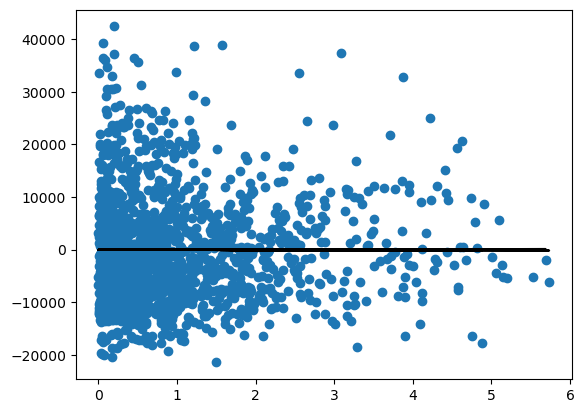

In [93]:
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth[365:])
winds_ros = y_mean4[mask]
winds_ros

slope,intercept = np.polyfit(np.abs(winds_haro_bclin),res_haro_bclin,1)
w_line_harobclin = slope*winds_haro_bclin+intercept
plt.scatter(np.abs(winds_haro_bclin),res_haro_bclin)
plt.plot(np.abs(winds_haro_bclin),w_line_harobclin,color='k')
plt.show()

corr_winds_resharo,p = stats.spearmanr(np.abs(winds_haro_bclin),res_haro_bclin)

slope,intercept = np.polyfit(np.abs(winds_ros),res_ros,1)
wline_ros = slope*np.abs(winds_ros)+intercept

corr_winds_resros,p = stats.spearmanr(np.abs(winds_ros),res_ros)

0.8275095665123892
-0.23675170365400924
0.8373202716143249
-0.17034334678090354


/tmp/ipykernel_31549/1051105028.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.arange(0,35000,5000),color=color1)
/tmp/ipykernel_31549/1051105028.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax12.set_yticklabels(np.arange(4,17,2),color=color2)
/tmp/ipykernel_31549/1051105028.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(np.arange(-10000,23000,10000),color=color3)
/tmp/ipykernel_31549/1051105028.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)
/tmp/ipykernel_31549/1051105028.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_yticklabels(np.arange(-10000,23000,10000),color=color3)


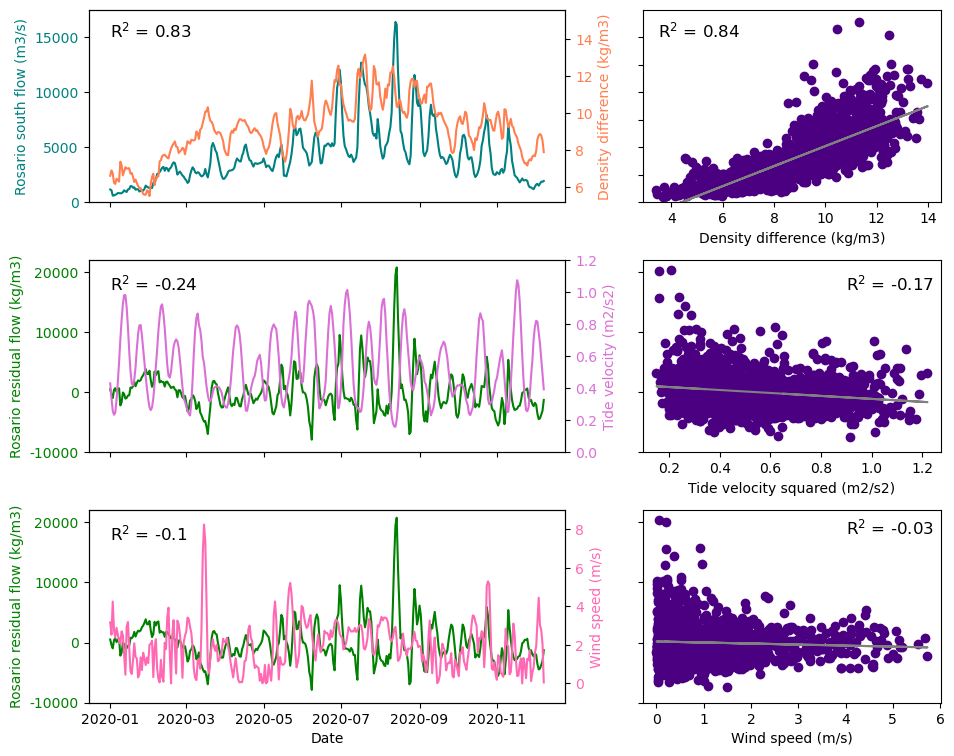

In [148]:
corr_ros2020_dd,p = stats.spearmanr(densdiff_ros2020,rostosouth_2020)
print(corr_ros2020_dd)
corr_ros_res2020,p = stats.spearmanr(tides_ros2020,res_ros2020)
print(corr_ros_res2020)
corr_ros_dd,p = stats.spearmanr(densdiff_ros,rostosouth[365:])
print(corr_ros_dd)
corr_ros_res,p = stats.spearmanr(tides_ros,res_ros)
print(corr_ros_res)

fig,[[ax1,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(11,9),gridspec_kw={'width_ratios':[1.6,1]})
ax1.plot(rostosouth_2020,color=color1)
ax1.set_xticklabels([])
ax12 = ax1.twinx()
ax12.plot(datelist_rostosouth_2020,densdiff_ros2020,color=color2)
ax1.set_ylim([0,35000])
ax1.set_ylabel('Rosario south flow (m3/s)',color=color1)
ax1.set_yticklabels(np.arange(0,35000,5000),color=color1)
ax12.set_ylabel('Density difference (kg/m3)',color=color2)
ax12.set_ylim([4,17])
ax12.set_yticklabels(np.arange(4,17,2),color=color2)
ax1.annotate(f'R$^2$ = {np.round(corr_ros2020_dd,2)}',(datelist_rostosouth_2020.iloc[0],30000),fontsize=12)

ax2.scatter(densdiff_ros,rostosouth[365:],color='indigo')
ax2.plot(densdiff_ros,ddline_ros,color='grey')
ax2.set_ylim([0,35000])
ax2.set_yticks(np.arange(0,35000,5000))
ax2.set_yticklabels([])
ax2.set_xlabel('Density difference (kg/m3)')
ax2.annotate(f'R$^2$ = {np.round(corr_ros_dd,2)}',(3.5,30000),fontsize=12)

ax3.plot(res_ros2020,color='green',zorder=0)
ax32 = ax3.twinx()
ax32.plot(datelist_rostosouth_2020,tides_ros2020,color='orchid')
ax3.set_ylim([-10000,22000])
ax5.set_xlabel('Date')
ax3.set_ylabel('Rosario residual flow (kg/m3)',color=color3)
ax32.set_ylabel('Tide velocity (m2/s2)',color=color4)
ax3.set_yticklabels(np.arange(-10000,23000,10000),color=color3)
ax32.set_ylim([0,1.2])
ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)
ax32.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{1}f}}'))
ax3.annotate(f'R$^2$ = {np.round(corr_ros_res2020,2)}',(datelist_rostosouth_2020.iloc[0],17000),fontsize=12)
ax3.set_xticklabels([])
ax4.scatter(tides_ros,res_ros,color='indigo')
ax4.plot(tides_ros,tline_ros,color='grey')
ax4.set_ylim([-10000,22000])
ax4.set_yticklabels([])
ax4.set_xlabel('Tide velocity squared (m2/s2)')
ax4.annotate(f'R$^2$ = {np.round(corr_ros_res,2)}',(0.9,17000),fontsize=12)

fig.subplots_adjust(wspace=0.2,hspace=0.3);

ax5.plot(datelist_rostosouth_2020,res_ros2020,color='green')
ax5.set_ylim([-10000,22000])
ax5.set_ylabel('Rosario residual flow (kg/m3)',color=color3)
ax5.set_yticklabels(np.arange(-10000,23000,10000),color=color3)
ax52 = ax5.twinx()
ax52.plot(datelist_rostosouth_2020,np.abs(winds_ros2020),color='hotpink')
ax52.set_ylim([-1,9])
ax52.set_yticks(np.arange(0,9,2),color='hotpink')
ax52.set_yticklabels(np.arange(0,9,2),color='hotpink')
ax52.set_ylabel('Wind speed (m/s)',color='hotpink')
ax5.annotate(f'R$^2$ = {np.round(corr_winds_resros2020,2)}',(datelist_rostosouth_2020.iloc[0],17000),fontsize=12)

ax6.scatter(np.abs(winds_ros),res_ros,color='indigo')
ax6.plot(np.abs(winds_ros),wline_ros,color='grey')
ax6.set_ylim([-10000,22000])
ax6.set_yticklabels([])
ax6.set_xlabel('Wind speed (m/s)')
ax6.annotate(f'R$^2$ = {np.round(corr_winds_resros,2)}',(4,18000),fontsize=12);


In [149]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/ros_south_correlations.png',bbox_inches='tight')

In [95]:
x = np.array([1,2,3,4,5,6,7,8,9,10])
y = np.array([3,2,1,0,-1,-2,-3,-2,-1,0])

stats.spearmanr(x,y)

SignificanceResult(statistic=-0.6666947244376294, pvalue=0.03525468046844947)

^^ Absolute value of winds

SignificanceResult(statistic=0.00039040181610844327, pvalue=0.9880961734925342)

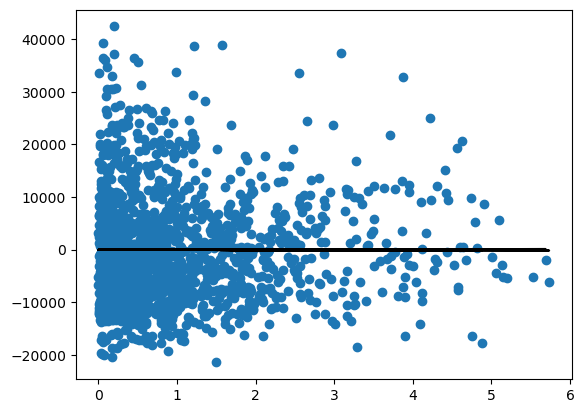

In [96]:
slope,intercept = np.polyfit(np.abs(winds_haro_bclin),res_haro_bclin,1)
w_line_harobclin = slope*winds_haro_bclin+intercept
plt.scatter(np.abs(winds_haro_bclin),res_haro_bclin)
plt.plot(np.abs(winds_haro_bclin),w_line_harobclin,color='k')

stats.spearmanr(np.abs(winds_haro_bclin),res_haro_bclin)

# slope,intercept = np.polyfit(winds_ros,res_ros,1)
# w_line_ros = slope*winds_ros+intercept
# plt.scatter(winds_ros,res_ros)
# plt.plot(winds_ros,w_line_ros,color='k')


### Winds

#### Rosario

In [97]:
-corr_ros_res2018,corr_winds_resros2018,corr_winds_rr_resros2018,corr_ssh_resros2018

(0.18251455375465928,
 -0.08189625338632421,
 0.21062043851934145,
 0.011358872114322745)

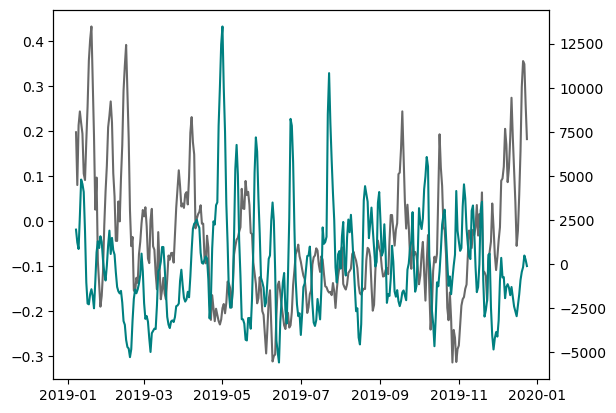

In [98]:
fig,ax = plt.subplots()
ax.plot(datelist_rostosouth_2019,ssh_ros2019,color='dimgrey')
ax2 = ax.twinx()
ax2.plot(res_ros2019,color='teal')

### Winds and baroclinic haro

In [99]:
res_haro_bclin2018

mask = np.isin(datelist_winds,date_haro2018)
winds_haro2018 = y_mean4[mask]
corr_wind_resharo2018,p = stats.spearmanr(np.abs(winds_haro2018),res_haro_bclin2018)
print(corr_wind_resharo2018)

#2019
mask = np.isin(datelist_winds,date_haro2019)
winds_haro2019 = y_mean4[mask]
corr_wind_resharo2019,p = stats.spearmanr(np.abs(winds_haro2019),res_haro_bclin2019)
print(corr_wind_resharo2019)

#2020
mask = np.isin(datelist_winds,date_haro2020)
winds_haro2020 = y_mean4[mask]
corr_wind_resharo2020,p = stats.spearmanr(np.abs(winds_haro2020),res_haro_bclin2020)
print(corr_wind_resharo2020)

#2021
mask = np.isin(datelist_winds,date_haro2021)
winds_haro2021 = y_mean4[mask]
corr_wind_resharo2021,p = stats.spearmanr(np.abs(winds_haro2021),res_haro_bclin2021)
print(corr_wind_resharo2021)

slope,intercept = np.polyfit(tides_haro_bclin2018,res_haro_bclin2018,1)
tline_haro2018 = slope*tides_haro_bclin2018+intercept
res2_haro_bclin2018 = res_haro_bclin2018.values - tline_haro2018.values
corr,p = stats.spearmanr(np.abs(winds_haro2018),res2_haro_bclin2018)
print('Res2:',corr)

slope,intercept = np.polyfit(tides_haro_bclin2019,res_haro_bclin2019,1)
tline_haro2019 = slope*tides_haro_bclin2019+intercept
res2_haro_bclin2019 = res_haro_bclin2019.values - tline_haro2019.values
corr,p = stats.spearmanr(np.abs(winds_haro2019),res2_haro_bclin2019)
print(corr)

slope,intercept = np.polyfit(tides_haro_bclin2020,res_haro_bclin2020,1)
tline_haro2020 = slope*tides_haro_bclin2020+intercept
res2_haro_bclin2020 = res_haro_bclin2020.values - tline_haro2020.values
corr,p = stats.spearmanr(np.abs(winds_haro2020),res2_haro_bclin2020)
print(corr)

slope,intercept = np.polyfit(tides_haro_bclin2021,res_haro_bclin2021,1)
tline_haro2021 = slope*tides_haro_bclin2021+intercept
res2_haro_bclin2021 = res_haro_bclin2021.values - tline_haro2021.values
corr,p = stats.spearmanr(np.abs(winds_haro2021),res2_haro_bclin2021)
print(corr)

-0.07471192158663727
-0.01781681491313219
0.12358539958659802
-0.03003319068849971
Res2: -0.11369375476372111
0.0015416201676824903
-0.009420480647885022
-0.06519331216295222


### Baroclinic haro correlations

In [100]:
# Calculate all correlations

mask = np.isin(datelist_winds,date_haro2018)
winds_haro2018_rr = y_mean4_rr[mask]
corr_wind_resharo2018_rr,p = stats.spearmanr(winds_haro2018_rr,res_haro_bclin2018)
print(corr_wind_resharo2018_rr)

#2019
mask = np.isin(datelist_winds,date_haro2019)
winds_haro2019_rr = y_mean4_rr[mask]
corr_wind_resharo2019_rr,p = stats.spearmanr(winds_haro2019_rr,res_haro_bclin2019)
print(corr_wind_resharo2019_rr)

#2020
mask = np.isin(datelist_winds,date_haro2020)
winds_haro2020_rr = y_mean4_rr[mask]
corr_wind_resharo2020_rr,p = stats.spearmanr(winds_haro2020_rr,res_haro_bclin2020)
print(corr_wind_resharo2020_rr)

#2021
mask = np.isin(datelist_winds,date_haro2021)
winds_haro2021_rr = y_mean4_rr[mask]
corr_wind_resharo2021_rr,p = stats.spearmanr(winds_haro2021_rr,res_haro_bclin2021)
print(corr_wind_resharo2021_rr)

mask = np.isin(datelist_ssh,date_haro2018)
ssh_haro2018 = ssh_jdf[mask]
corr_ssh_resharo2018,p = stats.spearmanr(ssh_haro2018,res_haro_bclin2018)
print('EJdF:',corr_ssh_resharo2018)

mask = np.isin(datelist_ssh,date_haro2019)
ssh_haro2019 = ssh_jdf[mask]
corr_ssh_resharo2019,p = stats.spearmanr(ssh_haro2019,res_haro_bclin2019)
print(corr_ssh_resharo2019)

mask = np.isin(datelist_ssh,date_haro2020)
ssh_haro2020 = ssh_jdf[mask]
corr_ssh_resharo2020,p = stats.spearmanr(ssh_haro2020,res_haro_bclin2020)
print(corr_ssh_resharo2020)

mask = np.isin(datelist_ssh,date_haro2021)
ssh_haro2021 = ssh_jdf[mask]
corr_ssh_resharo2021,p = stats.spearmanr(ssh_haro2021,res_haro_bclin2021)
print(corr_ssh_resharo2021)

corr_tides_resbclin_2018,p = stats.spearmanr(tides_haro_bclin2018,res_haro_bclin2018)
print('Tides:',corr_tides_resbclin_2018)
corr_tides_resbclin_2019,p = stats.spearmanr(tides_haro_bclin2019,res_haro_bclin2019)
print(corr_tides_resbclin_2019)
corr_tides_resbclin_2020,p = stats.spearmanr(tides_haro_bclin2020,res_haro_bclin2020)
print(corr_tides_resbclin_2020)
corr_tides_resbclin_2021,p = stats.spearmanr(tides_haro_bclin2021,res_haro_bclin2021)
print(corr_tides_resbclin_2021)

0.041443498726730456
-0.017717763822579686
0.05217187353410264
0.18835282299037895
EJdF: 0.23857048540880765
0.11799708789793775
0.2036564587248698
0.09812466830982729
Tides: -0.6348249855665014
-0.6836877711523602
-0.6514452423970052
-0.6336373084143115


### add winds to plot

-0.6367412347905815
0.7977244510764375
-0.6514452423970052
0.7529608478674692


/tmp/ipykernel_31549/3152910296.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.arange(0,120000,20000),color=color1)
/tmp/ipykernel_31549/3152910296.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax12.set_yticklabels(np.arange(4,15,2),color=color2)
/tmp/ipykernel_31549/3152910296.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)


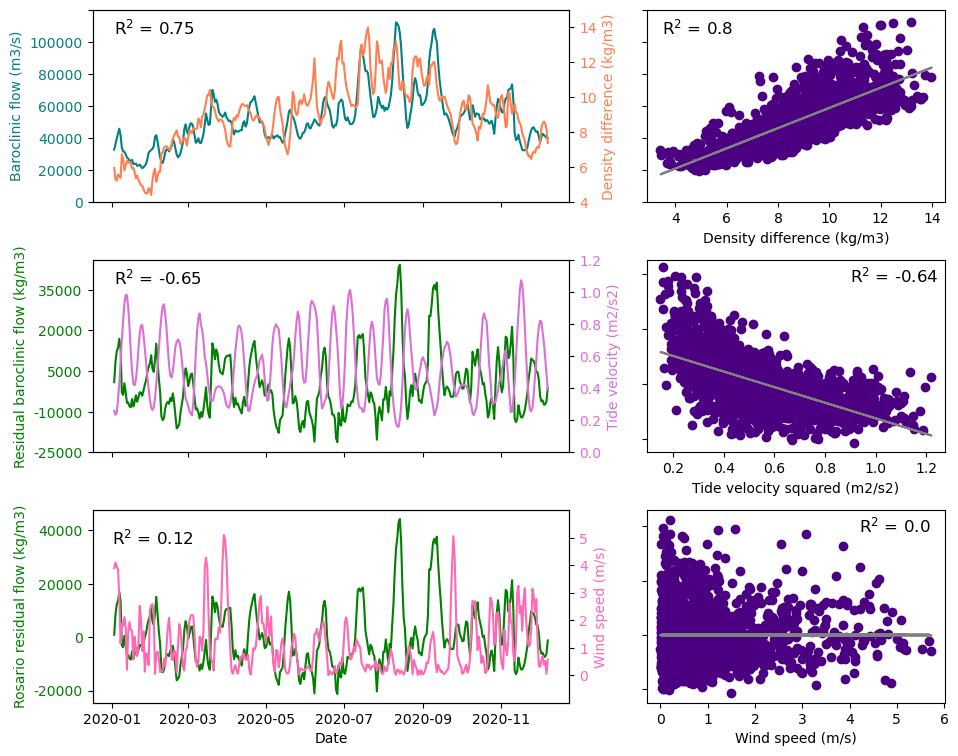

In [146]:
color1 = 'teal'
color2 = 'coral'
color3 = 'green'
color4 = 'orchid'

corr_tides_res,p = stats.spearmanr(tides_haro_bclin,res_haro_bclin.dropna())
print(corr_tides_res)

corr_bclin_dd,p = stats.spearmanr(densdiff_haro_bclin,haro_bclin.dropna())
print(corr_bclin_dd)

corr_tides_res_2020,p = stats.spearmanr(tides_haro_bclin2020,res_haro_bclin2020.dropna())
print(corr_tides_res_2020)

corr_bclin_dd_2020,p = stats.spearmanr(densdiff_haro_bclin2020,haro_bclin2020.dropna())
print(corr_bclin_dd_2020)

fig,[[ax1,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(11,9),gridspec_kw={'width_ratios':[1.6,1]})

ax1.plot(haro_bclin2020,color=color1)
ax1.set_xticklabels([])
ax12 = ax1.twinx()
ax12.plot(date_haro2020,densdiff_haro_bclin2020,color=color2)
ax1.set_ylim([0,120000])
ax1.set_ylabel('Baroclinic flow (m3/s)',color=color1)
ax1.set_yticklabels(np.arange(0,120000,20000),color=color1)
ax12.set_ylabel('Density difference (kg/m3)',color=color2)
ax12.set_ylim([4,15])
ax12.set_yticklabels(np.arange(4,15,2),color=color2)
ax1.annotate(f'R$^2$ = {np.round(corr_bclin_dd_2020,2)}',(date_haro2020[0],105000),fontsize=12)

ax2.scatter(densdiff_haro_bclin,haro_bclin,color='indigo')
ax2.plot(densdiff_haro_bclin,line_bclin_dd,color='grey')
ax2.set_ylim([0,120000])
ax2.set_yticklabels([])
ax2.set_xlabel('Density difference (kg/m3)')
ax2.annotate(f'R$^2$ = {np.round(corr_bclin_dd,2)}',(3.5,105000),fontsize=12)

ax3.plot(res_haro_bclin2020,color=color3)
ax32 = ax3.twinx()
ax32.plot(date_haro2020,tides_haro_bclin2020,color=color4)
ax3.set_ylim([-25000,46000])

ax3.set_ylabel('Residual baroclinic flow (kg/m3)',color=color3)
ax32.set_ylabel('Tide velocity (m2/s2)',color=color4)
ax3.set_yticks(np.arange(-25000,46000,15000),color=color3)
ax3.set_yticklabels(np.arange(-25000,46000,15000),color=color3)
ax32.set_ylim([0,1.2])
ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)
ax32.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{1}f}}'))
ax3.annotate(f'R$^2$ = {np.round(corr_tides_res_2020,2)}',(date_haro2020[0],37000),fontsize=12)
ax3.set_xticklabels([])
ax4.scatter(tides_haro_bclin,res_haro_bclin.dropna(),color='indigo')
ax4.plot(tides_haro_bclin,line_res_tides,color='grey')
ax4.set_ylim([-25000,45000])
ax4.set_yticklabels([])
ax4.set_xlabel('Tide velocity squared (m2/s2)')
ax4.annotate(f'R$^2$ = {np.round(corr_tides_res,2)}',(0.9,37000),fontsize=12)

fig.subplots_adjust(wspace=0.2,hspace=0.3)

ax5.plot(date_haro2020,res_haro_bclin2020,color='green')
ax5.set_ylabel('Rosario residual flow (kg/m3)',color=color3)
ax6.set_ylim([-25000,46000])
ax5.set_yticks(np.arange(-20000,45000,20000),color=color3)
ax5.set_yticklabels(np.arange(-20000,45000,20000),color=color3)
ax52 = ax5.twinx()
ax52.plot(date_haro2020,np.abs(winds_haro2020),color='hotpink')
ax52.set_ylim([-1,6])
ax52.set_yticks(np.arange(0,6,1),color='hotpink')
ax52.set_yticklabels(np.arange(0,6,1),color='hotpink')
ax52.set_ylabel('Wind speed (m/s)' ,color='hotpink')
ax5.annotate(f'R$^2$ = {np.round(corr_wind_resharo2020,2)}',(datelist_rostosouth_2020.iloc[0],35000),fontsize=12)
ax5.set_xlabel('Date')

ax6.scatter(np.abs(winds_haro_bclin),res_haro_bclin,color='indigo')
ax6.plot(np.abs(winds_haro_bclin),w_line_harobclin,color='grey')
ax6.set_yticklabels([])
ax6.set_xlabel('Wind speed (m/s)')
ax6.annotate(f'R$^2$ = {np.round(corr_winds_resharo,2)}',(4.2,38000),fontsize=12);

In [147]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/haro_bclin_correlations.png',bbox_inches='tight')

Slight positive correlation -> doesn't mean aythin

In [108]:
stats.spearmanr(tides_haro_bclin2020,winds_haro2020)

SignificanceResult(statistic=-0.07106065145613732, pvalue=0.19051530061590108)

### Barotropic Haro and winds

In [131]:
mask = np.isin(datelist_winds,date_haro_btrop)
winds_harobtrop = y_mean4[mask]

slope,intercept = np.polyfit(np.abs(winds_harobtrop),haro_btrop,1)
wline_harobtrop = slope*np.abs(winds_harobtrop)+intercept

-0.1421081673106057
-0.15055875820748338
0.012309149620644678
-0.1331371846475247
-0.10807843577702732


/tmp/ipykernel_31549/3920816474.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.arange(-20000,45000,10000),color=color1)
/tmp/ipykernel_31549/3920816474.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax12.set_yticklabels(np.arange(4,15,2),color=color2)
/tmp/ipykernel_31549/3920816474.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(np.arange(-20000,45000,10000),color=color1)
/tmp/ipykernel_31549/3920816474.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)
/tmp/ipykernel_31549/3920816474.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_yticklabels(np.arange(-20000,45000,10000),color=color1)
/tmp/ipykernel_31549/3920816474.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5

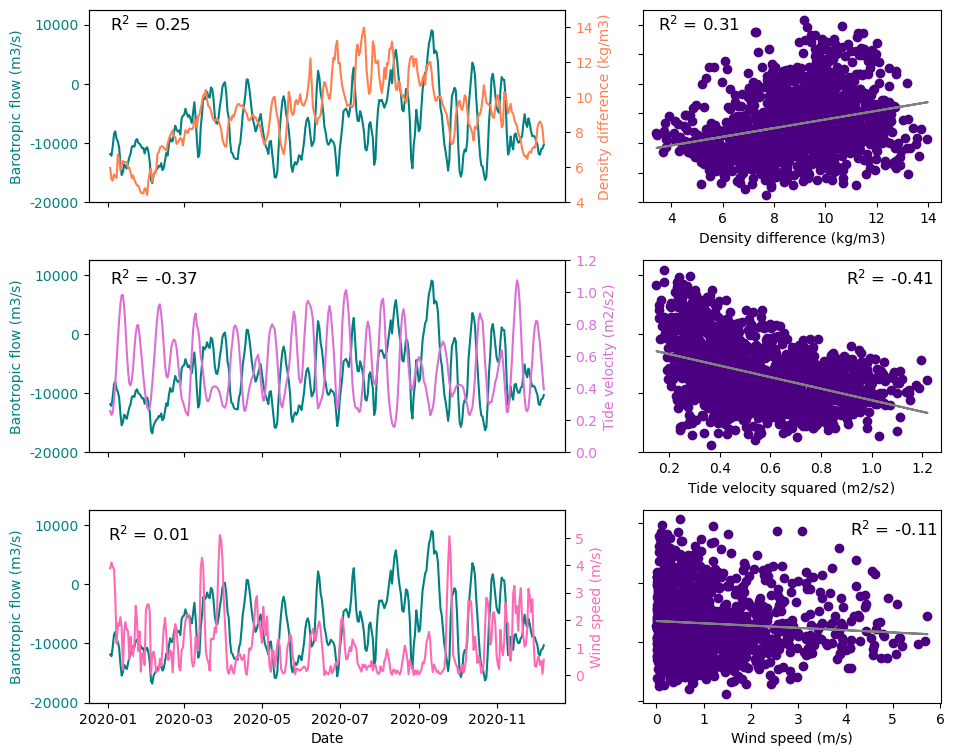

In [143]:
corr_winds_harobtrop_2018,p = stats.spearmanr(np.abs(winds_haro2018),haro_btrop2018)
print(corr_winds_harobtrop_2018)
corr_winds_harobtrop_2019,p = stats.spearmanr(np.abs(winds_haro2019),haro_btrop2019)
print(corr_winds_harobtrop_2019)
corr_winds_harobtrop_2020,p = stats.spearmanr(np.abs(winds_haro2020),haro_btrop2020)
print(corr_winds_harobtrop_2020)
corr_winds_harobtrop_2021,p = stats.spearmanr(np.abs(winds_haro2021),haro_btrop2021)
print(corr_winds_harobtrop_2021)
corr_winds_harobtrop,p = stats.spearmanr(np.abs(winds_harobtrop),haro_btrop)
print(corr_winds_harobtrop)

fig,[[ax1,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(11,9),gridspec_kw={'width_ratios':[1.6,1]})
ax1.plot(haro_btrop2020,color=color1)
ax1.set_xticklabels([])
ax12 = ax1.twinx()
ax12.plot(date_haro2020,densdiff_haro_btrop2020,color=color2)
ax1.set_ylim([-20000,45000])
ax1.set_ylabel('Barotropic flow (m3/s)',color=color1)
ax1.set_yticklabels(np.arange(-20000,45000,10000),color=color1)
ax12.set_ylabel('Density difference (kg/m3)',color=color2)
ax12.set_ylim([4,15])
ax12.set_yticklabels(np.arange(4,15,2),color=color2)
ax1.annotate(f'R$^2$ = {np.round(corr_btrop_dd_2020,2)}',(date_haro2020[0],38000),fontsize=12)

ax2.scatter(densdiff_haro_btrop,haro_btrop,color='indigo')
ax2.plot(densdiff_haro_btrop,line_btrop_dd,color='grey')
ax2.set_ylim([-20000,45000])
ax2.set_yticks(np.arange(-20000,45000,10000))
ax2.set_yticklabels([])
ax2.set_xlabel('Density difference (kg/m3)')
ax2.annotate(f'R$^2$ = {np.round(corr_btrop_dd,2)}',(3.5,38000),fontsize=12)

ax3.plot(haro_btrop2020,color=color1)
ax32 = ax3.twinx()
ax32.plot(date_haro2020,tides_haro_btrop2020,color=color4)
ax3.set_ylim([-20000,45000])
ax3.set_ylabel('Barotropic flow (m3/s)',color=color1)
ax32.set_ylabel('Tide velocity (m2/s2)',color=color4)
ax3.set_yticklabels(np.arange(-20000,45000,10000),color=color1)
ax32.set_ylim([0,1.2])
ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)
ax32.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{1}f}}'))
ax3.annotate(f'R$^2$ = {np.round(corr_btrop_tides_2020,2)}',(date_haro2020[0],37000),fontsize=12)
ax3.set_xticklabels([])
ax4.scatter(tides_haro_btrop,haro_btrop,color='indigo')
ax4.plot(tides_haro_btrop,line_btrop_tides,color='grey')
ax4.set_ylim([-20000,45000])
ax4.set_yticklabels([])
ax4.set_xlabel('Tide velocity squared (m2/s2)')
ax4.annotate(f'R$^2$ = {np.round(corr_btrop_tides,2)}',(0.9,37000),fontsize=12)

fig.subplots_adjust(wspace=0.2,hspace=0.3);

ax5.plot(haro_btrop2020,color=color1)
ax5.set_ylabel('Barotropic flow (m3/s)',color=color1)
ax5.set_ylim([-20000,45000])
ax5.set_yticklabels(np.arange(-20000,45000,10000),color=color1)
ax5.set_yticklabels(np.arange(-20000,45000,10000),color=color1)
ax52 = ax5.twinx()
ax52.plot(date_haro2020,np.abs(winds_haro2020),color='hotpink')
ax52.set_ylim([-1,6])
ax52.set_yticks(np.arange(0,6,1),color='hotpink')
ax52.set_yticklabels(np.arange(0,6,1),color='hotpink')
ax52.set_ylabel('Wind speed (m/s)' ,color='hotpink')
ax5.annotate(f'R$^2$ = {np.round(corr_winds_harobtrop_2020,2)}',(datelist_rostosouth_2020.iloc[0],35000),fontsize=12)
ax5.set_xlabel('Date')

ax6.scatter(np.abs(winds_harobtrop),haro_btrop,color='indigo')
ax6.plot(np.abs(winds_harobtrop),wline_harobtrop,color='grey')
ax6.set_yticklabels([])
ax6.set_xlabel('Wind speed (m/s)')
ax6.annotate(f'R$^2$ = {np.round(corr_winds_harobtrop,2)}',(4.1,36000),fontsize=12);

In [144]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/haro_btrop_correlations.png',bbox_inches='tight')

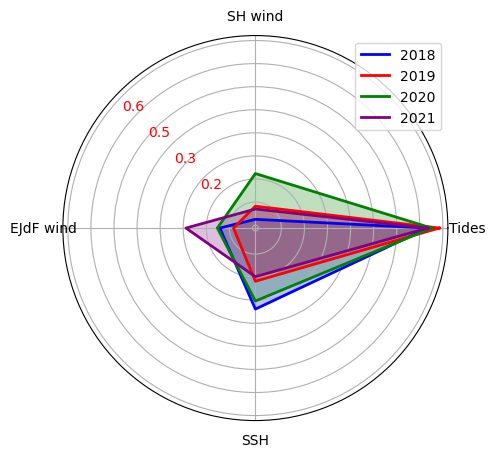

In [102]:

# Define labels and values
labels = np.array(['Tides', 'SH wind', 'EJdF wind', 'SSH'])
# values = np.array([3, 4, 2, 5])  # Example values for the variables
values = np.array([-corr_tides_resbclin_2018,corr_wind_resharo2018, corr_wind_resharo2018_rr,corr_ssh_resharo2018 ])  # 2018: tides, winds, ejdf winds, ssh
values2 = np.array([-corr_tides_resbclin_2019,corr_wind_resharo2019, corr_wind_resharo2019_rr,corr_ssh_resharo2019 ])  # 2019
values3 = np.array([-corr_tides_resbclin_2020,corr_wind_resharo2020, corr_wind_resharo2020_rr,corr_ssh_resharo2020 ])  # 2020
values4 = np.array([-corr_tides_resbclin_2021,corr_wind_resharo2021, corr_wind_resharo2021_rr,corr_ssh_resharo2021 ])  # 2021

values_ros = np.array([-corr_ros_res2018,corr_winds_resros2018,corr_winds_rr_resros2018,corr_ssh_resros2018])  # 2018: tides, winds, ejdf winds, ssh
# values2 = np.array([-corr_tides_resbclin_2019,corr_wind_resharo2019, corr_wind_resharo2019_rr,corr_ssh_resharo2019 ])  # 2019
# values3 = np.array([-corr_tides_resbclin_2020,corr_wind_resharo2020, corr_wind_resharo2020_rr,corr_ssh_resharo2020 ])  # 2020
# values4 = np.array([-corr_tides_resbclin_2021,corr_wind_resharo2021, corr_wind_resharo2021_rr,corr_ssh_resharo2021 ])  # 2021

# Calculate the angle for each axis
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Repeat the first angle to close the plot

# Plot
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
ax.fill(angles, np.concatenate((values, [values[0]])), color='blue', alpha=0.25)
ax.plot(angles, np.concatenate((values, [values[0]])), color='blue', linewidth=2,label='2018')
ax.fill(angles, np.concatenate((values2, [values2[0]])), color='red', alpha=0.25)
ax.plot(angles, np.concatenate((values2, [values2[0]])), color='red', linewidth=2,label='2019')
ax.fill(angles, np.concatenate((values3, [values3[0]])), color='green', alpha=0.25)
ax.plot(angles, np.concatenate((values3, [values3[0]])), color='green', linewidth=2,label='2020')
ax.fill(angles, np.concatenate((values4, [values4[0]])), color='purple', alpha=0.25)
ax.plot(angles, np.concatenate((values4, [values4[0]])), color='purple', linewidth=2,label='2021')

# Calculate the angle halfway between the first and second variables
half_angle = (angles[1] + angles[2]) / 2

# Add labels for circular lines halfway through the first quadrant
max_value = np.max(values)
num_lines = 4  # Number of circular lines
for i in range(1, num_lines + 1):
    value_at_line = max_value * i / num_lines
    label_angle = half_angle
    ax.text(label_angle, value_at_line, f'{value_at_line:.1f}', color='red', fontsize=10, ha='center', va='center')
    
# Set the labels
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])  # Exclude the last angle for better visualization
ax.set_xticklabels(labels)

ax.legend()

plt.show()


I don't think its useful to show this because I'm not really discussing any inter-annual variability ...

Or maybe I could discuss inter annual variability if I show this plot

--> Can discuss how rosario how less consistent correlation with tides

posx and posy should be finite values
posx and posy should be finite values


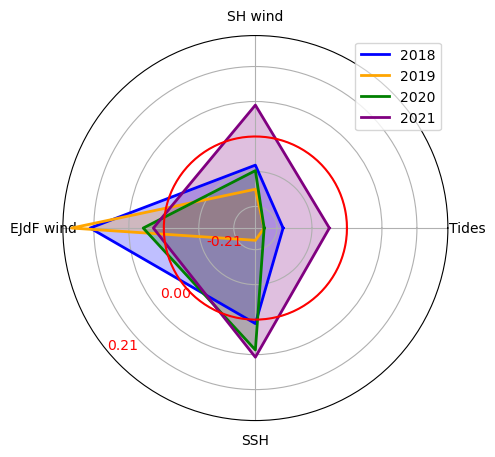

In [103]:

# Define labels and values
labels = np.array(['Tides', 'SH wind', 'EJdF wind', 'SSH'])
# values = np.array([3, 4, 2, 5])  # Example values for the variables

values = np.array([corr_ros_res2018,corr_winds_resros2018,corr_winds_rr_resros2018,corr_ssh_resros2018])  # 2018: tides, winds, ejdf winds, ssh
values2 = np.array([corr_ros_res2019,corr_winds_resros2019,corr_winds_rr_resros2019,corr_ssh_resros2019])  # 2019
values3 = np.array([corr_ros_res2020,corr_winds_resros2020,corr_winds_rr_resros2020,corr_ssh_resros2020 ])  # 2020
values4 = np.array([corr_ros_res2021,corr_winds_resros2021,corr_winds_rr_resros2021,corr_ssh_resros2021 ])  # 2021

# Calculate the angle for each axis
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Repeat the first angle to close the plot

# Plot
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
ax.fill(angles, np.concatenate((values, [values[0]])), color='blue', alpha=0.25)
ax.plot(angles, np.concatenate((values, [values[0]])), color='blue', linewidth=2,label='2018')
ax.fill(angles, np.concatenate((values2, [values2[0]])), color='orange', alpha=0.25)
ax.plot(angles, np.concatenate((values2, [values2[0]])), color='orange', linewidth=2,label='2019')
ax.fill(angles, np.concatenate((values3, [values3[0]])), color='green', alpha=0.25)
ax.plot(angles, np.concatenate((values3, [values3[0]])), color='green', linewidth=2,label='2020')
ax.fill(angles, np.concatenate((values4, [values4[0]])), color='purple', alpha=0.25)
ax.plot(angles, np.concatenate((values4, [values4[0]])), color='purple', linewidth=2,label='2021')

# Calculate the angle halfway between the first and second variables
half_angle = (angles[2] + angles[3]) / 2

# Add labels for circular lines halfway through the first quadrant
max_value = np.max(values)
num_lines = 1 # Number of circular lines
for i in range(-2, num_lines + 1):
    value_at_line = max_value * i / num_lines
    label_angle = half_angle
    ax.text(label_angle, value_at_line, f'{value_at_line:.2f}', color='red', fontsize=10, ha='right', va='center')
    
# Set the labels
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])  # Exclude the last angle for better visualization
ax.set_xticklabels(labels)

# Plot a red circular line where the circular line is 0
zero_radius = np.abs(values.min())  # Radius of the circle
zero_angle = np.linspace(0, 2 * np.pi, 100)
ax.plot(zero_angle, np.full_like(zero_angle, 0), color='red', linestyle='solid')  # Horizontal line at y=0

ax.legend()

plt.show()

Check correlations with separate ddline for each year

In [104]:
mask = np.isin(pd.to_datetime(datelist_dens),datelist_rostosouth_2018)
densdiff_ros18 = dens_diff_vspr[mask]
densdiff_ros18
slope,intercept = np.polyfit(densdiff_ros18,rostosouth_2018,1)
ddline18 = slope*densdiff_ros18+intercept
res18 = rostosouth_2018 - ddline18

mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2018)
winds18 = y_mean4[mask]

corr,p = stats.spearmanr(winds18,res18)
corr

0.1741105181599557

In [105]:
mask = np.isin(pd.to_datetime(datelist_dens),rostosouth[379:750].index)
densdiff_ros18 = dens_diff_ros[mask]
densdiff_ros18
slope,intercept = np.polyfit(densdiff_ros18,rostosouth[379:750],1)
ddline18 = slope*densdiff_ros18+intercept
res18 = rostosouth[379:750] - ddline18

mask = np.isin(pd.to_datetime(datelist_winds),rostosouth[379:750].index)
winds18 = y_mean4[mask]

corr,p = stats.spearmanr(winds18,res18)
corr


-0.10505643457560683